In [1]:
import random
import numpy as np
from enum import Enum 
import copy
from tqdm import tqdm_notebook, tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [3]:
# This method is adopted from https://github.com/mari-linhares
def plot_value_function(train_steps, usables, save_path, title='Value Function', agent=None, val_func=None, generate_gif=False):
    """
    This method is adopted from https://github.com/mari-linhares/easy21/blob/master/easy21.ipynb
    """
    """
    Plots a value function as a surface plot, like in: https://goo.gl/aF2doj

    You can choose between just plotting the graph for the value function
    which is the default behaviour (generate_gif=False) or to train the agent
    a couple of times and save the frames in a gif as you train.

    Args:
        agent: An agent.
        title (string): Plot title.
        generate_gif (boolean): If want to save plots as a gif.
        train_steps: If is not None and generate_gif = True, then will use this
                     value as the number of steps to train the model at each frame.
    """
    # you can change this values to change the size of the graph
    fig = plt.figure(title, figsize=(10, 5))
    
    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')
    if agent is None:
        V = np.transpose(val_func[:,:,usables[0],usables[1],usables[2]])
    else:
        V = np.transpose(agent.V[:,:,usables[0],usables[1],usables[2]])
    
    if generate_gif:
        print('gif will be saved as '+title)
    
    def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
        min_x = 0
        max_x = V.shape[0]
        min_y = 0
        max_y = V.shape[1]

        # creates a sequence from min to max
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # creates a grid representation of x_range and y_range
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        # check documentation for details: https://goo.gl/etEhPP
        ax.set_xlabel('Dealer Showing(usuable)')
        ax.set_ylabel('Agent Sum')
        ax.set_zlabel('Value')
#          cmap=cm.coolwarm
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu, 
                               linewidth=0, antialiased=False)

    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
        if generate_gif:
            i = agent.iterations
            # cool math to increase number of steps as we go
            if train_steps is None:
                step_size = int(min(max(1, agent.iterations), 2 ** 16))
            else:
                step_size = train_steps

            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        else:
            plt.title(title)

        fig.canvas.draw()
        return surf

    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

#     requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.savefig(save_path)
        plt.show()
        plt.close("All")

## Achieve 31 Rules

- We now have two types of colored cards - black and red. Black cards are drawn with a probability ⅔  and red cards are drawn with a probability of ⅓. 
- The cards are assumed to be drawn from an infinite deck of cards, with values ranging from 1 to 10. We assume that each card value is equally likely.
- The (black) cards showing 1, 2 and 3 are special cards and can take special values (described below). Note that only the black cards showing 1,2 and 3 are special. All the red cards take their normal values. The player has the flexibility of using the special cards at their original value or at a much higher value of 11, 12 and 13 respectively, depending on current requirements. Further, we will assume that for each special type (1,2 or 3), only the first card of that type will be allowed the special status, after which the cards would behave normally (as explained in the class). Finally, you can assume that each player is rational in using the value of these cards towards achieving the goal.
- Black cards contribute positively value towards the total sum. Red cards contribute negatively towards the total sum. For example, having two black cards with values 5,6 and a red card with value 7, will result in a total sum of 5+6-7=4.
- The goal of the game is to reach a sum value which is as close to 31 as possible. Each player can either stick (stop) or hit (continue playing). If the sum of cards of a player goes negative or if it goes more than 31, then the player goes bust and the player loses.   
- Both the agent and dealer start with one card in their hands. The dealer’s card is visible to the agent. 
- Agent starts the game and follows a policy. Once it sticks (or goes bust in which case it loses), the dealer starts.
- The dealer follows a fixed policy: keep on playing until you can reach a sum of 25 or more. Once this happens, the dealer sticks.
- The agent wins the game if (1) None of the player goes bust and agent’s total sum is more than the dealer’s sum in the end (2) Dealer goes bust after agent having played successfully (i.e., not going bust). Agent loses if it goes bust. If none of the above happens, that game is a draw.
- Special Circumstances: 
    - The game is a draw if both the dealer and the agent have a negative card in the beginning (both of them would have gone bust).
    - The player wins the game automatically if in the beginning (a) the player has a positive card AND (b) the dealer has a negative card (and hence goes bust right away).

## Deck

In [4]:
class Card():
    def __init__(self, color, value):
        self.color = color
        self.value = value

    def print(self):
        print(self.color+" "+str(self.value))

class Deck():
    def __init__(self, black_prob=2/3, red_prob=1/3, min_val=1, max_val=10):
        self.black_prob = black_prob
        self.red_prob = red_prob
        self.min_val = min_val
        self.max_val = max_val

    def sample(self):
        card_colors = ['black', 'red']
        color = np.random.choice(card_colors, p=[self.black_prob, self.red_prob])
        value = np.random.randint(self.min_val, self.max_val+1)
        return Card(color, value)

## State, Action

In [5]:
class State():
    def __init__(self, agent_score, dealer_score, is_terminal=False):
        self.agent_first_card = agent_score
        self.dealer_first_card  = dealer_score
        self.agent_score = agent_score
        self.dealer_score  = dealer_score
        self.is_terminal = is_terminal
        """
        0: not present
        1: present and usuable
        2: present and non-usuable (either because it is the first one and sum>31 or it is not the first one)
        """
        self.dealer_usuables = [0,0,0]
        self.agent_usuables = [0,0,0]
        
    def get_index_tuple(self):
        return (self.agent_score, self.dealer_first_card-4, self.agent_usuables[0], self.agent_usuables[1], self.agent_usuables[2])
    
    def print(self):
        print("((",self.agent_score, self.dealer_score, self.agent_first_card, self.dealer_first_card, self.is_terminal, self.agent_usuables, self.dealer_usuables,"))")
        
class Action(Enum):
    STICK = 0
    HIT = 1

## Player

In [6]:
class Player(object):
    def policy(self, state):
        # [TODO]
        raise NotImplemented()

class Dealer(Player):
    def policy(self, state):
        if state.dealer_score<25:
            return Action.HIT
        else:
            return Action.STICK

## Environment

In [7]:
class Environment():
    def __init__(self):
        self.deck = Deck()
        self.dealer = Dealer()
    
    def reset(self):
        dealer_card = self.get_card()
        agent_card = self.get_card()
        dealer_usuables = [0,0,0]
        agent_usuables = [0,0,0]
        if dealer_card==1 or dealer_card==2 or dealer_card==3:
            dealer_usuables[dealer_card-1]=1
            dealer_card+=10
        if agent_card==1 or agent_card==2 or agent_card==3:
            agent_usuables[agent_card-1]=1
            agent_card+=10
        s = State(agent_card,dealer_card)
        s.agent_usuables = agent_usuables
        s.dealer_usuables = dealer_usuables
        if self.busted(s.agent_score) or self.busted(s.dealer_score):
            s.is_terminal = True
        return s
            

    def busted(self, player_score):
        if player_score<0 or player_score>31:
            return True
        else:
            return False
    
    def get_card(self):
        card = self.deck.sample()
        if card.color=='red':
            return -1*card.value
        else:
            return card.value
    
    def get_next_state_dealer(self,card_value,state):
        if card_value==1 or card_value==2 or card_value==3:
            if state.dealer_usuables[card_value-1]==0:
                newval = state.dealer_score+card_value+10
                if newval>=0 and newval<32:
                    state.dealer_score += card_value+10
                    state.dealer_usuables[card_value-1]=1
                else:
                    state.dealer_score += card_value
                    state.dealer_usuables[card_value-1]=2
            elif state.dealer_usuables[card_value-1]==1:
                state.dealer_score += card_value
                state.dealer_usuables[card_value-1]=2
            else:
                state.dealer_score += card_value
        else:
            state.dealer_score += card_value
        return state
    
    def get_next_state_agent(self,card_value,state):
        if card_value==1 or card_value==2 or card_value==3:
            if state.agent_usuables[card_value-1]==0:
                newval = state.agent_score+card_value+10
                if newval>=0 and newval<32:
                    state.agent_score += card_value+10
                    state.agent_usuables[card_value-1]=1
                else:
                    state.agent_score += card_value
                    state.agent_usuables[card_value-1]=2
            elif state.agent_usuables[card_value-1]==1:
                state.agent_score += card_value
                state.agent_usuables[card_value-1]=2
            else:
                state.agent_score += card_value
        else:
            state.agent_score += card_value
        return state
    
    def play_dealer(self,state):
        action = None
        while(not state.is_terminal and action!=Action.STICK):
            action = self.dealer.policy(state)
            if action==Action.HIT:
                card_value = self.get_card()
                state = self.get_next_state_dealer(card_value,copy.deepcopy(state))
            state.is_terminal = self.busted(state.dealer_score)
        return state 
    
    def step(self, state, action):
        if state.is_terminal:
            raise ValueError("You cannot take an action on a Terminal State")()
        next_state = copy.deepcopy(state)
        if action==Action.HIT:
            card_value = self.get_card()
            next_state = self.get_next_state_agent(card_value, copy.deepcopy(next_state))
            next_state.is_terminal = self.busted(next_state.agent_score)
            if next_state.is_terminal:
                reward = -1
            else:
                reward = 0
        else:
#             print("Agent chose to STICK")
#             next_state.print()
            next_state = self.play_dealer(copy.deepcopy(next_state))
#             print("State after dealer played")
            if next_state.is_terminal:
                reward = 1
            else:
                next_state.is_terminal = True
                if next_state.agent_score>next_state.dealer_score:
                    reward = 1
                elif next_state.agent_score<next_state.dealer_score:
                    reward = -1
                else:
                    reward = 0
#             next_state.print()
        if next_state.is_terminal:
            return next_state, reward, True
        else:
            return next_state, reward, False
            

## Agent

In [8]:
class Agent(Player):
    def __init__(self, env, discount=1):
        self.env = env
        self.discount = discount
        self.V = np.zeros([32,10,3,3,3])
        self.Q = np.zeros([32,10,3,3,3,2])
        
    def random_action(self):
        return Action.STICK if random.random()<=0.5 else Action.HIT
    
    def greedy_action(self,state):
        action = Action(np.argmax(self.Q[state.get_index_tuple()]))
        return action

## Monte Carlo Evaluation

In [10]:
class MonteCarlo(Agent):
    def __init__(self,env,discount=1):
        Agent.__init__(self,env,discount)
        """
        0-31: 32 values for agent sum
        4-13: 10 values for dealer first card
        0-2: usuables for 1
        0-2: usuables for 2
        0-3: usuables for 3
        """
        self.N_v = np.zeros([32,10,3,3,3])
        self.N_q = np.zeros([32,10,3,3,3,2])
        self.V = np.zeros([32,10,3,3,3])
        self.Q = np.zeros([32,10,3,3,3,2])
        
#     def get_value_function(self):
#         return self.V
    def policy(self,state):
        if state.agent_score<25:
            return Action.HIT
        else:
            return Action.STICK
        
    def get_episode_v(self):
        episode = []
        state = self.env.reset()
#         state.print()
#         if (state.is_terminal):
#             print("State is terminal")
        while(not state.is_terminal):
            action = self.policy(state)
            next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
            episode.append((state,action,reward))
            state = next_state
        return episode

    def get_episode_q(self):
        episode = []
        state = self.env.reset()
        i=0
#         state.print()
#         if (state.is_terminal):
#             print("State is terminal")
        while(not state.is_terminal):
            if i==0:
                action = self.random_action()
            else:
                action = self.policy(state)
            next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
            episode.append((state,action,reward))
            state = next_state
            i+=1
        return episode
    
    def train_v(self, num_iters, first_visit=False):
        e=0
        pbar = tqdm(total=num_iters)
#         for i in tqdm_notebook(range(num_iters)):
        while (e<num_iters):
            episode = self.get_episode_v()
            if len(episode)==0:
                continue
            G = 0
            state_tracker = set()
            for i, (s,a,r) in enumerate(episode):
#                 s.print()
                state_tuple = s.get_index_tuple()
#                 print(state_tuple)
                G = (self.discount**(len(episode)-1-i))*episode[-1][2]
                if first_visit:
                    if state_tuple not in state_tracker:
                        state_tracker.add(state_tuple)
                        self.N_v[state_tuple]+=1
                        self.V[state_tuple] = (1.0*(self.V[state_tuple]*(self.N_v[state_tuple]-1) + G))/ self.N_v[state_tuple]
                else:
                    self.N_v[state_tuple]+=1
                    self.V[state_tuple] = (1.0*(self.V[state_tuple]*(self.N_v[state_tuple]-1) + G))/ self.N_v[state_tuple]
            pbar.update(1)
            e+=1
        pbar.close()
        return self.V
    
    def train_q(self, num_iters, first_visit=False):
        e=0
        pbar = tqdm(total=num_iters)
#         for i in tqdm_notebook(range(num_iters)):
        while e<num_iters:
            episode = self.get_episode_q()
            if len(episode)==0:
                continue
            G = 0
            state_value_tracker = set()
            for i, (s,a,r) in enumerate(episode):
#                 s.print()
                state_value_tuple = s.get_index_tuple() + (a.value,)
#                 print(state_value_tuple)
                G = (self.discount**(len(episode)-1-i))*episode[-1][2]
                if first_visit:
                    if state_value_tuple not in state_value_tracker:
                        state_value_tracker.add(state_value_tuple)
                        self.N_q[state_value_tuple]+=1
                        self.Q[state_value_tuple] = (1.0*(self.Q[state_value_tuple]*(self.N_q[state_value_tuple]-1) + G))/ self.N_q[state_value_tuple]
                else:
                    self.N_q[state_value_tuple]+=1
                    self.Q[state_value_tuple] = (1.0*(self.Q[state_value_tuple]*(self.N_q[state_value_tuple]-1) + G))/ self.N_q[state_value_tuple]
#             if e!=0 and e%100==0:
#                 print(str(e)+" episodes done")
            pbar.update(1)
            e+=1
        pbar.close()
        return self.Q

Check Monte Carlo Evaluation

In [11]:
env = Environment()
mc = MonteCarlo(env)

In [12]:
Q = mc.train_q(100)

100%|██████████| 100/100 [00:00<00:00, 1155.56it/s]


In [13]:
V = mc.train_v(100, first_visit=True)

100%|██████████| 100/100 [00:00<00:00, 721.80it/s]


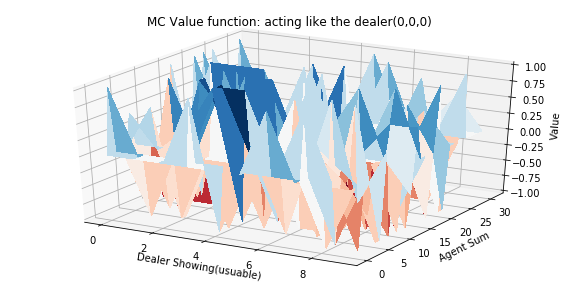

In [15]:
plot_value_function(val_func=V, train_steps=100, usables=[0,0,0], save_path ='mc-100-0-0-0-first.png' ,title='MC Value function: acting like the dealer(0,0,0)')

Helper function for saving value function plots of all valid states for every visit anf first visit MC

In [16]:
def train_and_save_MC(num_episodes, method):
    environment = Environment()
    mc = MonteCarlo(environment)
    V = mc.train_v(num_episodes, method)
    if method:
        m = 'first'
    else:
        m = 'every'
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                save_path = './MC/' + str(num_episodes) + '-' + str(i) + '-' + str(j) + '-' + str(k) + '-' + m + '.png'
                plot_value_function(agent=mc, train_steps=num_episodes, usables=[i,j,k], save_path=save_path, title = 'MC Value \
                function: acting like dealer ('+str(i) + ',' + str(j) + ',' + str(k)+')')

In [17]:
num_episodes = [100, 1000, 100000]
methods = [False,True] 
for n in num_episodes:
    for method in methods:
        train_and_save_MC(n, method)

## k-step TD Evaluation

In [18]:
class K_TD(Agent):
    def __init__(self,env,k,alpha=0.1,discount=1):
        Agent.__init__(self,env,discount)
        self.alpha = alpha
        self.k = k
        self.V = np.zeros([32,10,3,3,3])
        self.Q = np.zeros([32,10,3,3,3,2])

    def policy(self,state):
        if state.agent_score<25:
            return Action.HIT
        else:
            return Action.STICK
    
    def train_v(self, num_iters):
        # get a non-terminal state to start with
#         pbar = tqdm(total=num_iters)
        for n in range(num_iters):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            episode_states = {}
            episode_states[0] = state.get_index_tuple()
            T = float('inf')
            t = 0
            tau = t-self.k+1
            G = 0
            
            while(tau!=T-1):
#                 state.print()
                if t<T:
                    action = self.policy(state)
                    next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
#                     print(terminated)
                    episode_states[t+1] = next_state.get_index_tuple()
                    state = next_state
                    if state.is_terminal:
                        T = t+1
#                         print(T,t)
                tau = t-self.k+1
                if tau>=0:
                    G = 0
                    if T!=float('inf'):
#                         print("1: ", tau,T)
                        G = (self.discount**(T-tau-1))*reward
                    if tau+self.k<T:
                        G = G + (self.discount**self.k)*self.V[episode_states[tau+self.k]]
#                     print(tau, episode_states[tau], episode_states)
                    self.V[episode_states[tau]] += self.alpha*(G-self.V[episode_states[tau]])   
                t+=1
#             pbar.update(1)
#         pbar.close()
        return self.V
    
    def train_q(self, num_iters):
        # get a non-terminal state to start with
        pbar = tqdm(total=num_iters)
        for n in range(num_iters):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.random_action()
            episode_states = {}
            episode_states[0] = state.get_index_tuple()+(action.value,)
            T = float('inf')
            t = 0
            tau = t-self.k+1
            G = 0
            random = True
            while(tau!=T-1):
#                 state.print()
                if t<T:   
                    next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
                    action = self.policy(next_state)
#                     print(terminated)
                    episode_states[t+1] = next_state.get_index_tuple()+ (action.value,)
                    state = next_state
                    if state.is_terminal:
                        T = t+1
#                         print(T,t)
                tau = t-self.k+1
                if tau>=0:
                    G = 0
                    if T!=float('inf'):
#                         print("1: ", tau,T)
                        G = (self.discount**(T-tau-1))*reward
                    if tau+self.k<T:
                        G += (self.discount**self.k)*self.Q[episode_states[tau+self.k]]
#                     print(tau, episode_states[tau], episode_states)
                    self.Q[episode_states[tau]] += self.alpha*(G-self.Q[episode_states[tau]])   
                t+=1
            pbar.update(1)
        pbar.close()
        return self.Q

Check k-step TD Evaluation

In [19]:
env = Environment()
td = K_TD(env,k=1)
V = td.train_v(100)

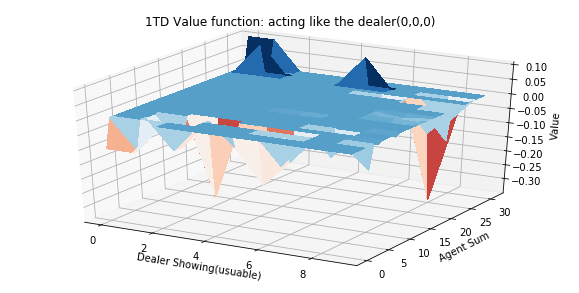

In [20]:
plot_value_function(val_func=V, train_steps=100, usables=[0,0,0], save_path ='1TD-100-0-0-0-first.png' ,title='1TD Value function: acting like the dealer(0,0,0)' )

Helper function for saving value function plots of all valid states for k step TD evaluation with k=1,3,5,10,100,1000 and value function averaged over 100 and 1000 runs

In [21]:
avg_nums = [100,1000]
ks = [1,3,5,10,100,1000]
num_iters = 10000
for k in tqdm_notebook(ks):
        V_100 = np.zeros([32,10,3,3,3])
        V_1000 = np.zeros([32,10,3,3,3])
        for i in tqdm_notebook(range(1000)):
            ktd = K_TD(env, k=k)
            V+=ktd.train_v(num_iters)
            if i==99:
                final_v_100 = V/100
        final_v_1000 = V/1000
#         print(k, avg_num, final_v.shape)
#         print(final_v)
        for a in range(3):
            for b in range(3):
                for c in range(3):
                    plot_value_function(val_func=final_v_100, train_steps=num_iters, usables=[a,b,c], save_path='./TD/'+ str(k) + 'TD-num' + str(100) +'-(' + str(a) + '-' + str(b) + '-' + str(c) + ')' + '.png', \
                            title='Value Function, '+str(k)+' step TD , '+str(avg_num)+' runs'+ '(' + str(a) + ',' + str(b) + ',' + str(c) + ')' )
                    plot_value_function(val_func=final_v_1000, train_steps=num_iters, usables=[a,b,c], save_path='./TD/'+ str(k) + 'TD-num' + str(1000) +'-(' + str(a) + '-' + str(b) + '-' + str(c) + ')' + '.png', \
                            title='Value Function, '+str(k)+' step TD , '+str(avg_num)+' runs'+ '(' + str(a) + ',' + str(b) + ',' + str(c) + ')' )

## k - step SARSA

In [22]:
class k_SARSA_Control(Agent):
    def __init__(self, env, k, alpha=0.1, discount=1):
        Agent.__init__(self,env,discount)
        self.alpha = alpha
        self.k = k
        self.V = np.zeros([32,10,3,3,3])
        self.Q = np.zeros([32,10,3,3,3,2])
        
    def e_greedy_action(self, epsilon, state):
        p = random.random()
        if p<epsilon:
            action = self.random_action()
        else:
            action = self.greedy_action(state)
        return action
    
    def policy(self, state):
        action = self.greedy_action(state)
        return action
    
    def gen_test_episodes(self,num_episodes):
        rewards = []
        for n in tqdm_notebook(range(num_episodes)):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.policy(state)
            total_rewards = []
            while(not state.is_terminal):
                next_state, reward, _ = self.env.step(copy.deepcopy(state),action)
                total_rewards.append(reward)
                state = next_state
                action = self.policy(state)
            avg_reward = (1.0*sum(total_rewards))/len(total_rewards)
            rewards.append(avg_reward)
        return (1.0*sum(rewards))/num_episodes
            
    def get_max_q(self,state):
        action = self.greedy_action(state)
        return self.Q[state.get_index_tuple()+(action.value,)]
    
    def get_value_function(self):
        for i in range(32):
            for j in range(10):
                for a in range(3):
                    for b in range(3):
                        for c in range(3):
                            s = State(i,j+4)
                            s.agent_usuables = [a,b,c]
                            self.V[s.get_index_tuple()] = self.get_max_q(s)
        return self.V
        
    def control(self, epsilon, num_iters, decay_e=False, get_rewards=False):
        # get a non-terminal state to start with
        pbar = tqdm(total=num_iters)
        rewards = []
        for n in range(num_iters):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.random_action()
            episode_states = {}
            episode_states[0] = state.get_index_tuple()+(action.value,)
            eps = epsilon
            T = float('inf')
            t = 0
            tau = t-self.k+1
            G = 0
            e = 1
            random = True
            total_reward = 0
            while(tau!=T-1):
                if t<T:   
                    next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
                    total_reward+=reward
                    if not next_state.is_terminal:
                        action = self.e_greedy_action(eps, next_state)
                        episode_states[t+1] = next_state.get_index_tuple()+ (action.value,)
                    state = next_state
                    if state.is_terminal:
                        T = t+1
                tau = t-self.k+1
                if tau>=0:
                    G = 0
                    if T!=float('inf'):
                        G = (self.discount**(T-tau-1))*reward
                    if tau+self.k<T:
                        G += (self.discount**self.k)*self.Q[episode_states[tau+self.k]]
                    self.Q[episode_states[tau]] += self.alpha*(G-self.Q[episode_states[tau]])   
                    e+=1
                    if decay_e:
                        eps = epsilon/e
                t+=1
            rewards.append(total_reward)
            pbar.update(1)
        pbar.close()
        if get_rewards:
            return self.Q, (1.0*sum(rewards))/len(rewards)
        else:
            return self.Q

Check k-step Sarsa Control
- Without decaying Epsilon
- WIth decaying Epsilon

In [24]:
env = Environment()
sarsa = k_SARSA_Control(env, k=1)

In [25]:
Q = sarsa.control(epsilon=0.1, num_iters=100, decay_e=False)
V = sarsa.get_value_function()

100%|██████████| 100/100 [00:00<00:00, 1164.21it/s]


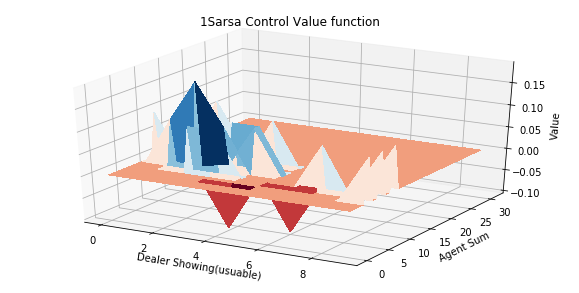

In [26]:
plot_value_function(val_func=V, train_steps=100, usables=[0,0,0], save_path ='1Sarsa-control-100-0-0-0-first.png' ,title='1Sarsa Control Value function')

100%|██████████| 100/100 [00:00<00:00, 1252.33it/s]


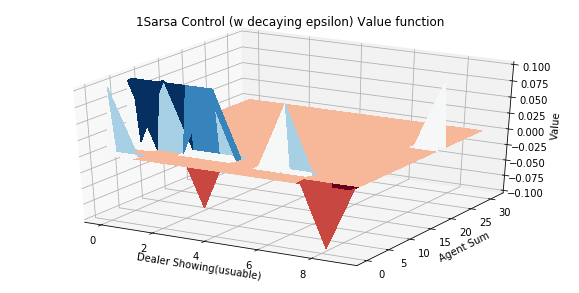

In [27]:
env = Environment()
sarsa = k_SARSA_Control(env, k=1)
Q = sarsa.control(epsilon=0.1, num_iters=100, decay_e=True)
V = sarsa.get_value_function()
plot_value_function(val_func=V, train_steps=100, usables=[0,0,0], save_path ='1Sarsa-control-decayE-100-0-0-0-first.png' ,title='1Sarsa Control (w decaying epsilon) Value function')

## Q Learning

In [28]:
class Q_Learner(Agent):
    def __init__(self, env, k=1, alpha=0.1, discount=1):
        Agent.__init__(self,env,discount)
        self.alpha = alpha
        self.k = k
        self.V = np.zeros([32,10,3,3,3])
        self.Q = np.zeros([32,10,3,3,3,2])
        
    def e_greedy_action(self, epsilon, state):
        p = random.random()
        if p<epsilon:
            action = self.random_action()
        else:
            action = self.greedy_action(state)
        return action
    
    def policy(self, state):
        action = self.greedy_action(state)
        return action
    
    def gen_test_episodes(self,num_episodes):
        rewards = []
        for n in tqdm_notebook(range(num_episodes)):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.policy(state)
            total_rewards = []
            while(not state.is_terminal):
                next_state, reward, _ = self.env.step(copy.deepcopy(state),action)
                total_rewards.append(reward)
                state = next_state
                action = self.policy(state)
            avg_reward = (1.0*sum(total_rewards))/len(total_rewards)
            rewards.append(avg_reward)
        return (1.0*sum(rewards))/num_episodes
    
    def get_max_q(self,state):
        action = self.greedy_action(state)
        return self.Q[state.get_index_tuple()+(action.value,)]
    
    def get_value_function(self):
        for i in range(32):
            for j in range(10):
                for a in range(3):
                    for b in range(3):
                        for c in range(3):
                            s = State(i,j+4)
                            s.agent_usuables = [a,b,c]
                            self.V[s.get_index_tuple()] = self.get_max_q(s)
        return self.V
        
    def control(self, epsilon, num_iters, decay_e=False, get_rewards=False):
        # get a non-terminal state to start with
        pbar = tqdm(total=num_iters)
        rewards = []
        for n in range(num_iters):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.random_action()
            episode_states = {}
            episode_states[0] = state.get_index_tuple()+(action.value,)
            eps = epsilon
            T = float('inf')
            t = 0
            tau = t-self.k+1
            G = 0
            e = 1
            random = True
            total_reward = 0
            while(tau!=T-1):
                if t<T:   
                    next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
                    total_reward+=reward
                    if not next_state.is_terminal:
                        action = self.e_greedy_action(eps, next_state)
                        episode_states[t+1] = next_state.get_index_tuple()+ (action.value,)
                    state = next_state
                    if state.is_terminal:
                        T = t+1
                tau = t-self.k+1
                if tau>=0:
                    G = 0
                    if T!=float('inf'):
                        G = (self.discount**(T-tau-1))*reward
                    if tau+self.k<T:
                        state_tuple = episode_states[tau+self.k][:-1]
                        _state = State(state_tuple[0],state_tuple[1])
                        _state.agent_usuables = [state_tuple[2],state_tuple[3],state_tuple[4]]
                        _action = self.greedy_action(_state)
                        G += (self.discount**self.k)*self.Q[state_tuple+(_action.value,)]
                    self.Q[episode_states[tau]] += self.alpha*(G-self.Q[episode_states[tau]])   
                    e+=1
                    if decay_e:
                        eps = epsilon/e
                t+=1
            rewards.append(total_reward)
            pbar.update(1)
        pbar.close()
        if get_rewards:
            return self.Q, (1.0*sum(rewards))/len(rewards)
        else:
            return self.Q

Check Q-Learning Control

In [30]:
env = Environment()
q_learner = Q_Learner(env)
Q = q_learner.control(epsilon=0.1, num_iters=100)
V = q_learner.get_value_function()

100%|██████████| 100/100 [00:00<00:00, 1272.98it/s]


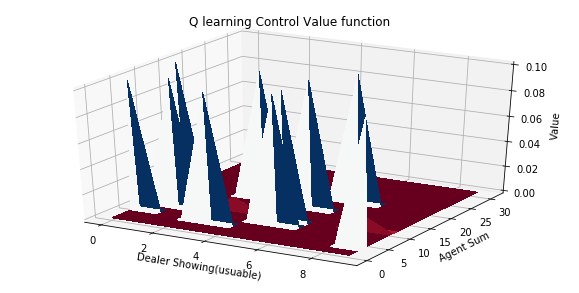

In [32]:
plot_value_function(val_func=V, train_steps=100, usables=[0,0,0], save_path ='Q-learning-control-100.png' ,title='Q learning Control Value function')

## Forward View Eligibility Traces

In [33]:
class TDLambda(Agent):
    def __init__(self, env, _lambda=0.5, alpha=0.1, discount=1):
        Agent.__init__(self,env,discount)
        self.alpha = alpha
        self._lambda = _lambda
        self.E = np.zeros([32,10,3,3,3,2])
        self.Q = np.zeros([32,10,3,3,3,2]) 
#         self.Q = np.random.uniform(low=-0.01, high=0.01, size=(32,10,3,3,3,2))
        
    def e_greedy_action(self, epsilon, state):
        p = random.random()
        if p<epsilon:
            action = self.random_action()
        else:
            action = self.greedy_action(state)
        return action
    
    def policy(self, state):
        action = self.greedy_action(state)
        return action
    
    def gen_test_episodes(self,num_episodes):
        rewards = []
        for n in tqdm_notebook(range(num_episodes)):
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.policy(state)
            total_rewards = []
            while(not state.is_terminal):
                next_state, reward, _ = self.env.step(copy.deepcopy(state),action)
                total_rewards.append(reward)
                state = next_state
                action = self.policy(state)
            avg_reward = (1.0*sum(total_rewards))/len(total_rewards)
            rewards.append(avg_reward)
        return (1.0*sum(rewards))/num_episodes
    
    def get_max_q(self,state):
        action = self.greedy_action(state)
        return self.Q[state.get_index_tuple()+(action.value,)]
    
    def get_value_function(self):
        for i in range(32):
            for j in range(10):
                for a in range(3):
                    for b in range(3):
                        for c in range(3):
                            s = State(i,j+4)
                            s.agent_usuables = [a,b,c]
                            self.V[s.get_index_tuple()] = self.get_max_q(s)
        return self.V
        
    def get_episode(self, epsilon, decay_e=True, random=False):
        episode = []
        state = self.env.reset()
        while(state.is_terminal):
            state = self.env.reset()
        i=1
        while(not state.is_terminal):
            if random:
                action = self.random_action()
            else:
                action = self.e_greedy_action(epsilon/i, state)
            next_state, reward, terminated = self.env.step(copy.deepcopy(state),action)
            episode.append((state,action,reward))
            state = next_state
            i+=1
        return episode
        
#     def get_G(self,t,episode):
#         G_t = 0
#         for i in range(t+1,len(episode)):
#             i_tup = episode[i][0].get_index_tuple()+(episode[i][1].value,)
#             if i!=len(episode)-1:
#                 G_t += (1-self._lambda)*(self._lambda**(i-t-1))*((self.discount**i-t)*Q[i_tup])
#             else:
#                 G_t += (1-self._lambda)*( (self._lambda**(i-t-1))*(self.discount**i-t)*Q[i_tup]\
#                                         + (self._lambda**(i-t-1))*(self.discount**i-t)*episode[i][2] )
#         return G_t
        
#     def control(self, epsilon, num_iters, decay=True):
#         for n in tqdm_notebook(range(1,num_iters+1)):
# #             if n==0:
# #                 episode = self.get_episode(epsilon, random=True)
# #             else:
#             episode = self.get_episode(epsilon/n, random=False)
# #             if len(episode)>1:
# #                 print(len(episode))
#             for t in range(len(episode)):
#                 G_t = self.get_G(t,episode)
# #                 if G_t!=0:
# #                     print(t,G_t)
#                 tup = episode[t][0].get_index_tuple()+(episode[t][1].value,)
#                 Q[tup] += self.alpha*(G_t - Q[tup]) 
#         return self.Q
    
    def control(self, epsilon, num_iters, get_rewards = False):
        rewards = []
        for n in tqdm_notebook(range(num_iters)):
            self.E = np.zeros([32,10,3,3,3,2])
            state = self.env.reset()
            while(state.is_terminal):
                state = self.env.reset()
            action = self.e_greedy_action(epsilon, copy.deepcopy(state))
            next_action = action
            i=1
            total_reward = 0
            while not state.is_terminal:
                next_state, reward, _ = self.env.step(copy.deepcopy(state), action)
                q = self.Q[state.get_index_tuple()+(action.value,)]
                if not next_state.is_terminal:
                    next_action = self.e_greedy_action(epsilon/i, copy.deepcopy(next_state))
                    q_next = self.Q[next_state.get_index_tuple()+(next_action.value,)]
                    delta = reward + (q_next - q) * self._lambda
                else:
                    delta = reward - q * self._lambda
                self.E[state.get_index_tuple()+(action.value,)] += 1
                update_q = self.alpha * delta * self.E
                self.Q += update_q
                self.E *= (self.discount * self._lambda)
                state = next_state
                action = next_action
                i+=1
                total_reward+=reward
            rewards.append(total_reward)
        if get_rewards:
            return self.Q, (1.0*sum(rewards))/len(rewards)
        else:
            return self.Q

Check TD Lambda Control with decaying epsilon
- for 100 episodes
- for 500000 episodes

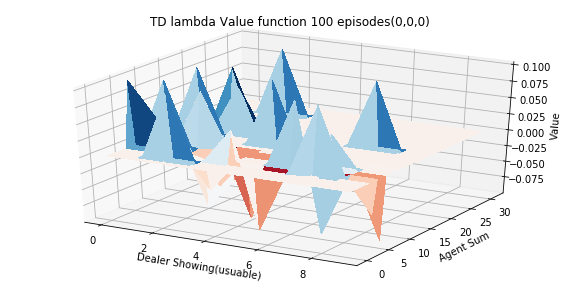

In [34]:
env = Environment()
td_lambda = TDLambda(env,alpha=0.1)
Q = td_lambda.control(epsilon=0.1,num_iters=100)
V = td_lambda.get_value_function()
plot_value_function(val_func=V, train_steps=100, usables=[0,0,0], save_path ='TD_lambda-100.png' ,title='TD lambda Value function 100 episodes(0,0,0)')

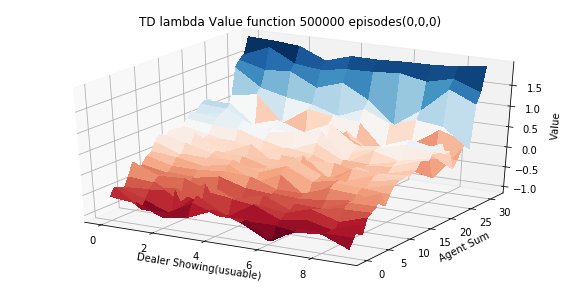

In [148]:
env = Environment()
td_lambda = TDLambda(env,alpha=0.1)
Q = td_lambda.control(epsilon=0.1,num_iters=500000)
V = td_lambda.get_value_function()
plot_value_function(val_func=V, train_steps=500000, usables=[0,0,0], save_path ='TD_lambda-500000.png' ,title='TD lambda Value function 500000 episodes(0,0,0)')

# Performance Analysis for Policy Control Algorithms

## Average total reward wrt number of episodes

In [204]:
num_runs = 10
num_episodes = 100
epsilon = 0.1

#### Sarsa 1




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 366.15it/s]


  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 413.99it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 621.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 663.92it/s]


  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 704.52it/s]


  0%|          | 0/6 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00, 613.37it/s]


  0%|          | 0/7 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 697.14it/s]


  0%|          | 0/8 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 735.04it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 555.07it/s]


  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 1023.43it/s]


  0%|          | 0/11 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 998.36it/s]


  0%|      

100%|██████████| 38/38 [00:00<00:00, 823.51it/s]


  0%|          | 0/39 [00:00<?, ?it/s]


100%|██████████| 39/39 [00:00<00:00, 835.49it/s]


  0%|          | 0/40 [00:00<?, ?it/s]


100%|██████████| 40/40 [00:00<00:00, 883.28it/s]


  0%|          | 0/41 [00:00<?, ?it/s]


100%|██████████| 41/41 [00:00<00:00, 805.00it/s]


  0%|          | 0/42 [00:00<?, ?it/s]


100%|██████████| 42/42 [00:00<00:00, 826.97it/s]


  0%|          | 0/43 [00:00<?, ?it/s]


100%|██████████| 43/43 [00:00<00:00, 899.34it/s]


  0%|          | 0/44 [00:00<?, ?it/s]


100%|██████████| 44/44 [00:00<00:00, 867.70it/s]


  0%|          | 0/45 [00:00<?, ?it/s]


100%|██████████| 45/45 [00:00<00:00, 773.48it/s]


  0%|          | 0/46 [00:00<?, ?it/s]


100%|██████████| 46/46 [00:00<00:00, 700.61it/s]


  0%|          | 0/47 [00:00<?, ?it/s]


100%|██████████| 47/47 [00:00<00:00, 1040.06it/s]


  0%|          | 0/48 [00:00<?, ?it/s]


100%|██████████| 48/48 [00:00<00:00, 956.22it/s]


  0%|          | 0/49 [00:00

 91%|█████████ | 70/77 [00:00<00:00, 693.29it/s]


100%|██████████| 77/77 [00:00<00:00, 658.65it/s]


  0%|          | 0/78 [00:00<?, ?it/s]


100%|██████████| 78/78 [00:00<00:00, 866.46it/s]


  0%|          | 0/79 [00:00<?, ?it/s]


 68%|██████▊   | 54/79 [00:00<00:00, 537.31it/s]


100%|██████████| 79/79 [00:00<00:00, 522.37it/s]


  0%|          | 0/80 [00:00<?, ?it/s]


100%|██████████| 80/80 [00:00<00:00, 846.40it/s]


  0%|          | 0/81 [00:00<?, ?it/s]


100%|██████████| 81/81 [00:00<00:00, 1230.61it/s]


  0%|          | 0/82 [00:00<?, ?it/s]


100%|██████████| 82/82 [00:00<00:00, 1049.79it/s]


  0%|          | 0/83 [00:00<?, ?it/s]


100%|██████████| 83/83 [00:00<00:00, 972.16it/s]


  0%|          | 0/84 [00:00<?, ?it/s]


 99%|█████████▉| 83/84 [00:00<00:00, 820.39it/s]


100%|██████████| 84/84 [00:00<00:00, 762.09it/s]


  0%|          | 0/85 [00:00<?, ?it/s]


 86%|████████▌ | 73/85 [00:00<00:00, 722.45it/s]


100%|██████████| 85/85 [00:00<00:00, 666.24it/s]


  0%|  

100%|██████████| 8/8 [00:00<00:00, 1037.78it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 651.28it/s]


  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 757.50it/s]


  0%|          | 0/11 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 797.56it/s]


  0%|          | 0/12 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 951.34it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 837.46it/s]


  0%|          | 0/14 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 678.85it/s]


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:00<00:00, 629.01it/s]


  0%|          | 0/16 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:00<00:00, 903.39it/s]


  0%|          | 0/17 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:00<00:00, 740.67it/s]


  0%|          | 0/18 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 1020.71it/s]


  0%|          | 0/19 [00:00<?, 

100%|██████████| 51/51 [00:00<00:00, 847.57it/s]


  0%|          | 0/52 [00:00<?, ?it/s]


100%|██████████| 52/52 [00:00<00:00, 1180.53it/s]


  0%|          | 0/53 [00:00<?, ?it/s]


100%|██████████| 53/53 [00:00<00:00, 1030.72it/s]


  0%|          | 0/54 [00:00<?, ?it/s]


100%|██████████| 54/54 [00:00<00:00, 1048.94it/s]


  0%|          | 0/55 [00:00<?, ?it/s]


100%|██████████| 55/55 [00:00<00:00, 772.59it/s]


  0%|          | 0/56 [00:00<?, ?it/s]


100%|██████████| 56/56 [00:00<00:00, 967.07it/s]


  0%|          | 0/57 [00:00<?, ?it/s]


100%|██████████| 57/57 [00:00<00:00, 1235.22it/s]


  0%|          | 0/58 [00:00<?, ?it/s]


100%|██████████| 58/58 [00:00<00:00, 659.14it/s]


  0%|          | 0/59 [00:00<?, ?it/s]


100%|██████████| 59/59 [00:00<00:00, 844.91it/s]


  0%|          | 0/60 [00:00<?, ?it/s]


100%|██████████| 60/60 [00:00<00:00, 1120.81it/s]


  0%|          | 0/61 [00:00<?, ?it/s]


100%|██████████| 61/61 [00:00<00:00, 1389.42it/s]


  0%|          | 0/62 [

100%|██████████| 98/98 [00:00<00:00, 1375.60it/s]


  0%|          | 0/99 [00:00<?, ?it/s]


100%|██████████| 99/99 [00:00<00:00, 1301.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1444.79it/s]


  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 519.16it/s]


  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 458.95it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00, 690.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 580.47it/s]


  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 654.56it/s]


  0%|          | 0/6 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00, 962.11it/s]


  0%|          | 0/7 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 1165.50it/s]


  0%|          | 0/8 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 681.45it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


100%|█

  0%|          | 0/73 [00:00<?, ?it/s]


100%|██████████| 73/73 [00:00<00:00, 1493.38it/s]


  0%|          | 0/74 [00:00<?, ?it/s]


100%|██████████| 74/74 [00:00<00:00, 1362.30it/s]


  0%|          | 0/75 [00:00<?, ?it/s]


100%|██████████| 75/75 [00:00<00:00, 1039.23it/s]


  0%|          | 0/76 [00:00<?, ?it/s]


 88%|████████▊ | 67/76 [00:00<00:00, 665.65it/s]


100%|██████████| 76/76 [00:00<00:00, 613.43it/s]


  0%|          | 0/77 [00:00<?, ?it/s]


100%|██████████| 77/77 [00:00<00:00, 823.58it/s]


  0%|          | 0/78 [00:00<?, ?it/s]


100%|██████████| 78/78 [00:00<00:00, 977.68it/s]


  0%|          | 0/79 [00:00<?, ?it/s]


100%|██████████| 79/79 [00:00<00:00, 1029.50it/s]


  0%|          | 0/80 [00:00<?, ?it/s]


100%|██████████| 80/80 [00:00<00:00, 1080.63it/s]


  0%|          | 0/81 [00:00<?, ?it/s]


100%|██████████| 81/81 [00:00<00:00, 1088.01it/s]


  0%|          | 0/82 [00:00<?, ?it/s]


100%|██████████| 82/82 [00:00<00:00, 1166.76it/s]


  0%|          | 0/83 

  0%|          | 0/13 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 725.34it/s]


  0%|          | 0/14 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 645.38it/s]


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:00<00:00, 538.35it/s]


  0%|          | 0/16 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:00<00:00, 625.40it/s]


  0%|          | 0/17 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:00<00:00, 592.80it/s]


  0%|          | 0/18 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 379.75it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 968.26it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:00<00:00, 300.65it/s]


  0%|          | 0/21 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 519.02it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:00<00:00, 457.95it/s]


  0%|          | 0/23 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:00<00:00, 70

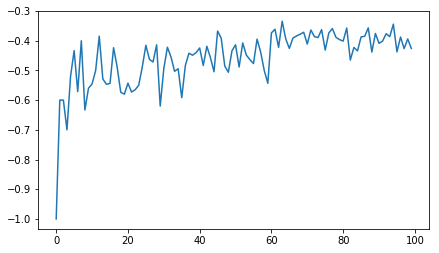

In [206]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_1 = k_SARSA_Control(env, k=1)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_1.control(epsilon,n,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_1_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(num_episodes), total_rewards)
plt.show()

#### Sarsa 1 decay




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1010.33it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1076.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1068.05it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 939.44it/s]


100%|██████████| 100/100 [00:00<00:00, 918.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1432.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1430.66it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1393.82it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1276.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 846.19it/s]


100%|██████████| 100/100 [00:00<00:00, 760.51it/s]


  0%|          | 0/100 [00:00<?

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1121.15it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 802.36it/s]


100%|██████████| 100/100 [00:00<00:00, 761.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 82%|████████▏ | 82/100 [00:00<00:00, 816.68it/s]


100%|██████████| 100/100 [00:00<00:00, 763.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1354.51it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 916.48it/s]


100%|██████████| 100/100 [00:00<00:00, 883.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 994.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1466.10it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1439.82it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00,

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1027.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 841.10it/s]


100%|██████████| 100/100 [00:00<00:00, 809.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1234.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1327.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1432.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1265.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1330.14it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1339.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1132.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 908.3

100%|██████████| 100/100 [00:00<00:00, 1013.08it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1133.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1248.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1359.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1303.62it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1254.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1138.64it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 849.98it/s]


100%|██████████| 100/100 [00:00<00:00, 799.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1070.51it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 925.16it/s]


100%|██████████| 100/100 [00:00<0

 64%|██████▍   | 64/100 [00:00<00:00, 626.70it/s]


100%|██████████| 100/100 [00:00<00:00, 630.95it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 807.17it/s]


100%|██████████| 100/100 [00:00<00:00, 801.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 863.87it/s]


100%|██████████| 100/100 [00:00<00:00, 836.83it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1152.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1236.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 996.04it/s]





  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 838.12it/s]


100%|██████████| 100/100 [00:00<00:00, 770.28it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 858.22it/s]


100%|██████████| 100/100 [00:00<00:00, 806.30it/s]


  0%|          | 

 66%|██████▌   | 66/100 [00:00<00:00, 611.40it/s]


100%|██████████| 100/100 [00:00<00:00, 537.92it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 71%|███████   | 71/100 [00:00<00:00, 703.36it/s]


100%|██████████| 100/100 [00:00<00:00, 693.18it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 53%|█████▎    | 53/100 [00:00<00:00, 522.17it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 432.12it/s]


100%|██████████| 100/100 [00:00<00:00, 431.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 958.47it/s]


100%|██████████| 100/100 [00:00<00:00, 933.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1128.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1339.31it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1179.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1035.20it/s]


  0%|          | 0

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1316.05it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 75%|███████▌  | 75/100 [00:00<00:00, 746.81it/s]


100%|██████████| 100/100 [00:00<00:00, 726.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 70%|███████   | 70/100 [00:00<00:00, 696.47it/s]


100%|██████████| 100/100 [00:00<00:00, 729.57it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1059.86it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 879.18it/s]


100%|██████████| 100/100 [00:00<00:00, 864.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 917.69it/s]


100%|██████████| 100/100 [00:00<00:00, 876.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 858.18it/s]


100%|██████████| 100/100 [00:00<00:00, 838.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<

100%|██████████| 100/100 [00:00<00:00, 1138.16it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 941.67it/s]


100%|██████████| 100/100 [00:00<00:00, 904.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 903.91it/s]


100%|██████████| 100/100 [00:00<00:00, 823.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 82%|████████▏ | 82/100 [00:00<00:00, 813.97it/s]


100%|██████████| 100/100 [00:00<00:00, 782.38it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 848.10it/s]


100%|██████████| 100/100 [00:00<00:00, 836.00it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 735.34it/s]


100%|██████████| 100/100 [00:00<00:00, 701.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1210.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1313.52it/s]


  0%|          | 0/

100%|██████████| 100/100 [00:00<00:00, 1183.72it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1281.33it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1297.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1184.81it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 83%|████████▎ | 83/100 [00:00<00:00, 825.85it/s]


100%|██████████| 100/100 [00:00<00:00, 776.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1038.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 76%|███████▌  | 76/100 [00:00<00:00, 757.49it/s]


100%|██████████| 100/100 [00:00<00:00, 769.26it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 802.86it/s]


100%|██████████| 100/100 [00:00<00:00, 774.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1039.53it/s]


  0%|          | 0/100 [0

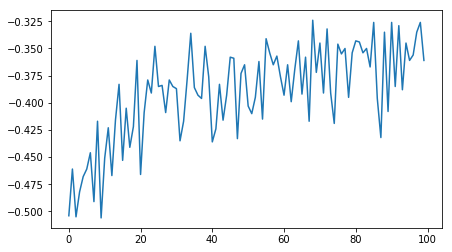

In [207]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_decay_1 = k_SARSA_Control(env, k=1)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_decay_1.control(epsilon,num_episodes,decay_e=True,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_decay_1_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### sarsa 10




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1111.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 872.56it/s]


100%|██████████| 100/100 [00:00<00:00, 839.56it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 997.76it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1487.76it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1220.76it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1270.05it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1601.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1249.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1479.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 10

 92%|█████████▏| 92/100 [00:00<00:00, 917.80it/s]


100%|██████████| 100/100 [00:00<00:00, 900.57it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1296.38it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1334.47it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1323.44it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1449.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1387.60it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1321.86it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 98%|█████████▊| 98/100 [00:00<00:00, 969.39it/s]


100%|██████████| 100/100 [00:00<00:00, 926.66it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1112.45it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00

100%|██████████| 100/100 [00:00<00:00, 1424.10it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1394.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1253.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1108.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1445.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1173.16it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1150.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1520.83it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1395.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1414.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1218.68it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1441.24it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1412.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1464.60it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1603.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1541.69it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1524.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1536.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1561.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1211.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1175.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1086.08it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1126.58it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1324.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1416.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1283.83it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1435.40it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1179.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1659.92it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1562.69it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1165.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1136.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1328.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1201.04it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 912.58it/s]


100%|██████████| 100/100 [00:00<00:00, 872.71it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 903.53it/s]


100%|██████████| 100/100 [00:00<00:00, 835.57it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 915.39it/s]


100%|██████████| 100/100 [00:00<00:00, 875.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1154.28it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00

 70%|███████   | 70/100 [00:00<00:00, 698.49it/s]


100%|██████████| 100/100 [00:00<00:00, 704.44it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 878.57it/s]


100%|██████████| 100/100 [00:00<00:00, 836.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 884.66it/s]


100%|██████████| 100/100 [00:00<00:00, 756.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 998.82it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1303.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 886.78it/s]


100%|██████████| 100/100 [00:00<00:00, 830.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 809.22it/s]


100%|██████████| 100/100 [00:00<00:00, 772.34it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 769.11it/s]


100%|██████████| 100/1

100%|██████████| 100/100 [00:00<00:00, 1191.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 893.68it/s]


100%|██████████| 100/100 [00:00<00:00, 852.15it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1412.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1471.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1018.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1382.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1224.92it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1427.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1328.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 983.40it/s]


100%|██████████| 100/100 [00:00<0

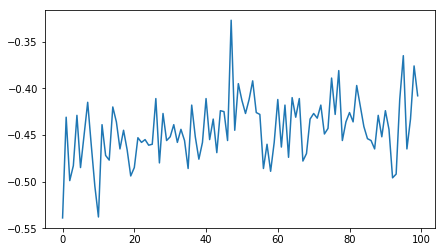

In [208]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_10 = k_SARSA_Control(env, k=10)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_10.control(epsilon,num_episodes,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_10_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### sarsa 10 decay




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1145.98it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 963.99it/s]


100%|██████████| 100/100 [00:00<00:00, 930.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1123.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1353.86it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1237.96it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1481.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1240.68it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1445.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1204.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 9

  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 738.57it/s]


100%|██████████| 100/100 [00:00<00:00, 745.15it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1151.99it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1175.89it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1155.31it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1257.36it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 838.65it/s]


100%|██████████| 100/100 [00:00<00:00, 754.57it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 865.58it/s]


100%|██████████| 100/100 [00:00<00:00, 841.44it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1025.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00,

100%|██████████| 100/100 [00:00<00:00, 1275.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 965.07it/s]


100%|██████████| 100/100 [00:00<00:00, 922.75it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 958.59it/s]


100%|██████████| 100/100 [00:00<00:00, 852.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1110.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 73%|███████▎  | 73/100 [00:00<00:00, 724.25it/s]


100%|██████████| 100/100 [00:00<00:00, 676.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1317.77it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1516.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1363.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1350.47it/s]


  0%|          | 0/100 [0

 88%|████████▊ | 88/100 [00:00<00:00, 872.31it/s]


100%|██████████| 100/100 [00:00<00:00, 803.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 774.49it/s]


100%|██████████| 100/100 [00:00<00:00, 759.68it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1312.44it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1139.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1137.49it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1075.00it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 879.74it/s]


100%|██████████| 100/100 [00:00<00:00, 884.04it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 876.75it/s]


100%|██████████| 100/100 [00:00<00:00, 831.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:

100%|██████████| 100/100 [00:00<00:00, 1122.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1271.24it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1149.95it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 927.98it/s]


100%|██████████| 100/100 [00:00<00:00, 886.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 896.57it/s]


100%|██████████| 100/100 [00:00<00:00, 875.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 844.46it/s]


100%|██████████| 100/100 [00:00<00:00, 791.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1131.98it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1126.76it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1250.80it/s]


  0%|          | 0/100 [0

 90%|█████████ | 90/100 [00:00<00:00, 896.16it/s]


100%|██████████| 100/100 [00:00<00:00, 789.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 95%|█████████▌| 95/100 [00:00<00:00, 941.81it/s]


100%|██████████| 100/100 [00:00<00:00, 883.69it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1145.15it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1116.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1170.08it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1098.91it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 823.83it/s]


100%|██████████| 100/100 [00:00<00:00, 791.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 926.88it/s]


100%|██████████| 100/100 [00:00<00:00, 881.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00

 91%|█████████ | 91/100 [00:00<00:00, 909.66it/s]


100%|██████████| 100/100 [00:00<00:00, 875.04it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1139.45it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 923.52it/s]


100%|██████████| 100/100 [00:00<00:00, 873.97it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1383.34it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1274.99it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1369.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1322.33it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1360.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1370.52it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00

 90%|█████████ | 90/100 [00:00<00:00, 891.80it/s]


100%|██████████| 100/100 [00:00<00:00, 866.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1197.00it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 839.24it/s]


100%|██████████| 100/100 [00:00<00:00, 796.62it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1078.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1180.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1137.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1142.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1144.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1203.83it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1316.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1447.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1391.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1515.20it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1537.26it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1526.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1220.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1152.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1456.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1003.47it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


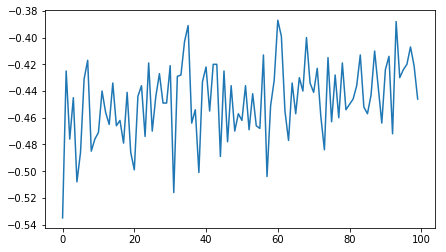

In [209]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_decay_10 = k_SARSA_Control(env, k=10)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_decay_10.control(epsilon,num_episodes,decay_e=True,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_decay_10_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### sarsa 100




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1235.27it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1256.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1364.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1060.22it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1282.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1210.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1063.37it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1454.80it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1420.84it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1227.42it/s]


  0%|          | 0/100 [00:00<?, ?it/

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1478.33it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1749.75it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1500.24it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 95%|█████████▌| 95/100 [00:00<00:00, 942.61it/s]


100%|██████████| 100/100 [00:00<00:00, 890.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1153.45it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1240.60it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1191.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1423.36it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1537.89it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1459

 80%|████████  | 80/100 [00:00<00:00, 793.35it/s]


100%|██████████| 100/100 [00:00<00:00, 740.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 95%|█████████▌| 95/100 [00:00<00:00, 949.08it/s]


100%|██████████| 100/100 [00:00<00:00, 897.96it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 974.77it/s]


100%|██████████| 100/100 [00:00<00:00, 874.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1024.62it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1262.37it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1268.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 794.51it/s]


100%|██████████| 100/100 [00:00<00:00, 738.28it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 69%|██████▉   | 69/100 [00:00<00:00, 670.25it/s]


100%|██████████| 100/100 [00:00<00:00, 665.00it/s]


  0%|          | 0/

 89%|████████▉ | 89/100 [00:00<00:00, 888.79it/s]


100%|██████████| 100/100 [00:00<00:00, 826.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 796.23it/s]


100%|██████████| 100/100 [00:00<00:00, 750.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1202.47it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1150.75it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1044.08it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1097.38it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1091.98it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 828.78it/s]


100%|██████████| 100/100 [00:00<00:00, 776.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 768.19it/s]


100%|██████████| 100/100 [0

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1267.25it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1341.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1201.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 884.71it/s]


100%|██████████| 100/100 [00:00<00:00, 843.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 999.72it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 995.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 856.03it/s]


100%|██████████| 100/100 [00:00<00:00, 829.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1122.51it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1269.63it/s]


  0%|          | 0/100 [00:00<?, ?it

 68%|██████▊   | 68/100 [00:00<00:00, 677.38it/s]


100%|██████████| 100/100 [00:00<00:00, 663.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1131.34it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1205.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1190.99it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 98%|█████████▊| 98/100 [00:00<00:00, 973.60it/s]


100%|██████████| 100/100 [00:00<00:00, 928.82it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1353.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1270.26it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 959.66it/s]


100%|██████████| 100/100 [00:00<00:00, 914.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 995.26it/s]





  0%|          | 0/100 

 91%|█████████ | 91/100 [00:00<00:00, 907.03it/s]


100%|██████████| 100/100 [00:00<00:00, 847.45it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 775.41it/s]


100%|██████████| 100/100 [00:00<00:00, 747.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1012.61it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1201.56it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1032.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1267.32it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1145.36it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 838.93it/s]


100%|██████████| 100/100 [00:00<00:00, 792.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 68%|██████▊   | 68/100 [00:00<00:00, 677.53it/s]


100%|██████████| 100/100 [0

100%|██████████| 100/100 [00:00<00:00, 1135.98it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1101.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 864.05it/s]


100%|██████████| 100/100 [00:00<00:00, 820.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 981.79it/s]


100%|██████████| 100/100 [00:00<00:00, 943.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1169.86it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 777.49it/s]


100%|██████████| 100/100 [00:00<00:00, 745.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1093.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1103.80it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1147.35it/s]


  0%|          | 0/100 [0

100%|██████████| 100/100 [00:00<00:00, 896.40it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 969.79it/s]


100%|██████████| 100/100 [00:00<00:00, 928.69it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1473.56it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1314.84it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1141.10it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1282.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1306.95it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 769.60it/s]


100%|██████████| 100/100 [00:00<00:00, 742.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 784.27it/s]


100%|██████████| 100/100 [00:00<00:00, 781.29it/s]


  0%|          | 0/100 [00

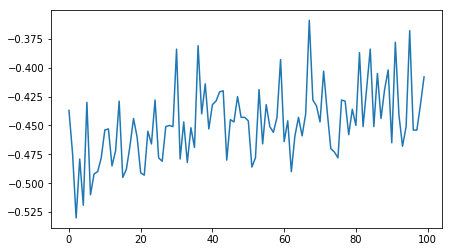

In [210]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_100 = k_SARSA_Control(env, k=100)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_100.control(epsilon,num_episodes,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_100_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### sarsa 100 decay




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1066.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1242.36it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1210.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 82%|████████▏ | 82/100 [00:00<00:00, 793.25it/s]


100%|██████████| 100/100 [00:00<00:00, 725.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 68%|██████▊   | 68/100 [00:00<00:00, 672.89it/s]


100%|██████████| 100/100 [00:00<00:00, 678.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 73%|███████▎  | 73/100 [00:00<00:00, 726.49it/s]


100%|██████████| 100/100 [00:00<00:00, 662.64it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1243.92it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1240.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00

100%|██████████| 100/100 [00:00<00:00, 1218.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1031.00it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 849.54it/s]


100%|██████████| 100/100 [00:00<00:00, 819.80it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 867.30it/s]


100%|██████████| 100/100 [00:00<00:00, 822.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 789.28it/s]


100%|██████████| 100/100 [00:00<00:00, 761.02it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1207.45it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1306.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1352.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1354.74it/s]


  0%|          | 0/100 [0

  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 854.58it/s]


100%|██████████| 100/100 [00:00<00:00, 826.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 991.75it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 918.51it/s]


100%|██████████| 100/100 [00:00<00:00, 850.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1121.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 878.80it/s]


100%|██████████| 100/100 [00:00<00:00, 826.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 936.43it/s]


100%|██████████| 100/100 [00:00<00:00, 899.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1177.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1145.83it/s]


  0%|          | 0/100 [00:00

100%|██████████| 100/100 [00:00<00:00, 779.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 778.52it/s]


100%|██████████| 100/100 [00:00<00:00, 751.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1064.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 809.21it/s]


100%|██████████| 100/100 [00:00<00:00, 763.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 664.00it/s]


100%|██████████| 100/100 [00:00<00:00, 644.02it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 799.80it/s]


100%|██████████| 100/100 [00:00<00:00, 775.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 73%|███████▎  | 73/100 [00:00<00:00, 724.05it/s]


100%|██████████| 100/100 [00:00<00:00, 725.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 986.85it/s]


100%|██████████| 100/1

100%|██████████| 100/100 [00:00<00:00, 720.60it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 83%|████████▎ | 83/100 [00:00<00:00, 820.88it/s]


100%|██████████| 100/100 [00:00<00:00, 812.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 765.32it/s]


100%|██████████| 100/100 [00:00<00:00, 733.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 55%|█████▌    | 55/100 [00:00<00:00, 543.95it/s]


100%|██████████| 100/100 [00:00<00:00, 618.60it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1344.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1354.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1100.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1190.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1259.59it/s]


  0%|          | 0/100 [00

 74%|███████▍  | 74/100 [00:00<00:00, 739.82it/s]


100%|██████████| 100/100 [00:00<00:00, 733.18it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 757.91it/s]


100%|██████████| 100/100 [00:00<00:00, 746.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 859.23it/s]


100%|██████████| 100/100 [00:00<00:00, 766.45it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 859.84it/s]


100%|██████████| 100/100 [00:00<00:00, 811.85it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 771.28it/s]


100%|██████████| 100/100 [00:00<00:00, 733.76it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 862.36it/s]


100%|██████████| 100/100 [00:00<00:00, 808.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 739.63it/s]


100%|██████████| 100/100 [00:00<00:00, 710.95it/s]


  0%|        

100%|██████████| 100/100 [00:00<00:00, 623.97it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 782.73it/s]


100%|██████████| 100/100 [00:00<00:00, 733.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 809.55it/s]


100%|██████████| 100/100 [00:00<00:00, 747.27it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 63%|██████▎   | 63/100 [00:00<00:00, 627.57it/s]


100%|██████████| 100/100 [00:00<00:00, 669.69it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 70%|███████   | 70/100 [00:00<00:00, 693.40it/s]


100%|██████████| 100/100 [00:00<00:00, 701.47it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 72%|███████▏  | 72/100 [00:00<00:00, 698.37it/s]


100%|██████████| 100/100 [00:00<00:00, 640.08it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 60%|██████    | 60/100 [00:00<00:00, 599.49it/s]


100%|██████████| 100/100 [00:00<00:00, 615.32it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 64%|██████▍   | 64/100

100%|██████████| 100/100 [00:00<00:00, 696.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 859.76it/s]


100%|██████████| 100/100 [00:00<00:00, 841.33it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 70%|███████   | 70/100 [00:00<00:00, 688.71it/s]


100%|██████████| 100/100 [00:00<00:00, 680.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 836.35it/s]


100%|██████████| 100/100 [00:00<00:00, 800.82it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 739.22it/s]


100%|██████████| 100/100 [00:00<00:00, 670.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 906.31it/s]


100%|██████████| 100/100 [00:00<00:00, 840.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 52%|█████▏    | 52/100 [00:00<00:00, 514.36it/s]


100%|██████████| 100/100 [00:00<00:00, 596.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/10

100%|██████████| 100/100 [00:00<00:00, 694.75it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 980.30it/s]


100%|██████████| 100/100 [00:00<00:00, 945.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 809.54it/s]


100%|██████████| 100/100 [00:00<00:00, 761.34it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1021.83it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 743.47it/s]


100%|██████████| 100/100 [00:00<00:00, 699.85it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 807.84it/s]


100%|██████████| 100/100 [00:00<00:00, 777.22it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 926.90it/s]


100%|██████████| 100/100 [00:00<00:00, 888.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 73%|███████▎  | 73/100 [00:00<00:00, 721.23it/s]


100%|██████████| 100/1

100%|██████████| 100/100 [00:00<00:00, 817.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1085.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1009.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1135.29it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1112.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 82%|████████▏ | 82/100 [00:00<00:00, 815.12it/s]


100%|██████████| 100/100 [00:00<00:00, 768.72it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 767.77it/s]


100%|██████████| 100/100 [00:00<00:00, 768.76it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 76%|███████▌  | 76/100 [00:00<00:00, 752.58it/s]


100%|██████████| 100/100 [00:00<00:00, 736.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 64%|██████▍   | 64/100 [00:00<00:00, 632.59it/s]


100%|██████████| 100/100 [00

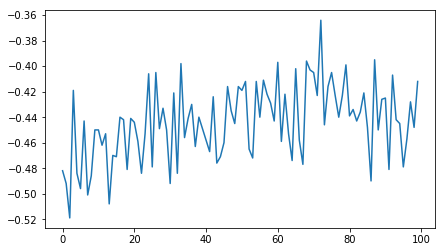

In [211]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_decay_100 = k_SARSA_Control(env, k=100)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_decay_100.control(epsilon,num_episodes,decay_e=True,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_decay_100_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### sarsa 1000




  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 660.17it/s]


100%|██████████| 100/100 [00:00<00:00, 626.04it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 773.78it/s]


100%|██████████| 100/100 [00:00<00:00, 715.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 736.52it/s]


100%|██████████| 100/100 [00:00<00:00, 738.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 968.26it/s]


100%|██████████| 100/100 [00:00<00:00, 902.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 98%|█████████▊| 98/100 [00:00<00:00, 977.09it/s]


100%|██████████| 100/100 [00:00<00:00, 929.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 879.42it/s]


100%|██████████| 100/100 [00:00<00:00, 825.40it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 958.73it/s]


100%|██████████| 100/

100%|██████████| 100/100 [00:00<00:00, 751.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1067.96it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 837.57it/s]


100%|██████████| 100/100 [00:00<00:00, 828.29it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1007.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 908.36it/s]


100%|██████████| 100/100 [00:00<00:00, 861.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 65%|██████▌   | 65/100 [00:00<00:00, 640.00it/s]


100%|██████████| 100/100 [00:00<00:00, 591.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 75%|███████▌  | 75/100 [00:00<00:00, 748.83it/s]


100%|██████████| 100/100 [00:00<00:00, 683.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 54%|█████▍    | 54/100 [00:00<00:00, 531.18it/s]


100%|██████████| 100/100 [00:00<00:00, 605.50it/s]


  0%|          | 0/1

  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 878.67it/s]


100%|██████████| 100/100 [00:00<00:00, 843.20it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 983.55it/s]


100%|██████████| 100/100 [00:00<00:00, 955.81it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 997.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 927.74it/s]


100%|██████████| 100/100 [00:00<00:00, 852.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 62%|██████▏   | 62/100 [00:00<00:00, 604.34it/s]


100%|██████████| 100/100 [00:00<00:00, 614.32it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 668.24it/s]


100%|██████████| 100/100 [00:00<00:00, 663.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 61%|██████    | 61/100 [00:00<00:00, 604.95it/s]


100%|██████████| 100/100 [00:00<00:00, 602.05it/s]


  0%|          | 0/100 

  0%|          | 0/100 [00:00<?, ?it/s]


 60%|██████    | 60/100 [00:00<00:00, 592.29it/s]


100%|██████████| 100/100 [00:00<00:00, 649.57it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1004.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 981.87it/s]


100%|██████████| 100/100 [00:00<00:00, 921.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 981.01it/s]


100%|██████████| 100/100 [00:00<00:00, 947.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 897.57it/s]


100%|██████████| 100/100 [00:00<00:00, 809.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 75%|███████▌  | 75/100 [00:00<00:00, 736.34it/s]


100%|██████████| 100/100 [00:00<00:00, 681.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 65%|██████▌   | 65/100 [00:00<00:00, 643.27it/s]


100%|██████████| 100/100 [00:00<00:00, 717.18it/s]


  0%|          | 0/100

 88%|████████▊ | 88/100 [00:00<00:00, 876.40it/s]


100%|██████████| 100/100 [00:00<00:00, 788.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 799.39it/s]


100%|██████████| 100/100 [00:00<00:00, 772.08it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 805.94it/s]


100%|██████████| 100/100 [00:00<00:00, 808.47it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 68%|██████▊   | 68/100 [00:00<00:00, 670.16it/s]


100%|██████████| 100/100 [00:00<00:00, 586.96it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 665.99it/s]


100%|██████████| 100/100 [00:00<00:00, 662.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 766.96it/s]


100%|██████████| 100/100 [00:00<00:00, 613.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 763.91it/s]


100%|██████████| 100/100 [00:00<00:00, 806.56it/s]


  0%|        

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1247.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1215.05it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1157.38it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1164.38it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1157.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1176.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 991.18it/s]





  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 911.95it/s]


100%|██████████| 100/100 [00:00<00:00, 884.10it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 86%|████████▌ | 86/100 [00:00<00:00, 859.10it/s]


100%|██████████| 100/100 [00:00<00:00, 763.20it/s]


  0%|          | 0/100 [00:00<?,

 98%|█████████▊| 98/100 [00:00<00:00, 974.98it/s]


100%|██████████| 100/100 [00:00<00:00, 934.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 902.98it/s]


100%|██████████| 100/100 [00:00<00:00, 826.81it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 932.60it/s]


100%|██████████| 100/100 [00:00<00:00, 900.49it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1024.18it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1156.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1105.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1122.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1026.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1098.27it/s]


  0%|          | 0/100 [0

 85%|████████▌ | 85/100 [00:00<00:00, 848.27it/s]


100%|██████████| 100/100 [00:00<00:00, 759.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 58%|█████▊    | 58/100 [00:00<00:00, 574.67it/s]


100%|██████████| 100/100 [00:00<00:00, 631.31it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 909.40it/s]


100%|██████████| 100/100 [00:00<00:00, 838.77it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 68%|██████▊   | 68/100 [00:00<00:00, 673.70it/s]


100%|██████████| 100/100 [00:00<00:00, 661.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 967.61it/s]


100%|██████████| 100/100 [00:00<00:00, 915.49it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 807.43it/s]


100%|██████████| 100/100 [00:00<00:00, 784.30it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1025.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/10

 79%|███████▉  | 79/100 [00:00<00:00, 789.33it/s]


100%|██████████| 100/100 [00:00<00:00, 760.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 82%|████████▏ | 82/100 [00:00<00:00, 811.67it/s]


100%|██████████| 100/100 [00:00<00:00, 729.95it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 60%|██████    | 60/100 [00:00<00:00, 594.09it/s]


100%|██████████| 100/100 [00:00<00:00, 584.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 668.58it/s]


100%|██████████| 100/100 [00:00<00:00, 699.15it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 58%|█████▊    | 58/100 [00:00<00:00, 579.14it/s]


100%|██████████| 100/100 [00:00<00:00, 557.60it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 764.69it/s]


100%|██████████| 100/100 [00:00<00:00, 746.77it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 935.98it/s]


100%|██████████| 100/100 [00:00<00:00, 870.13it/s]


  0%|        

100%|██████████| 100/100 [00:00<00:00, 745.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 65%|██████▌   | 65/100 [00:00<00:00, 647.29it/s]


100%|██████████| 100/100 [00:00<00:00, 670.00it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 60%|██████    | 60/100 [00:00<00:00, 590.70it/s]


100%|██████████| 100/100 [00:00<00:00, 574.25it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 58%|█████▊    | 58/100 [00:00<00:00, 573.20it/s]


100%|██████████| 100/100 [00:00<00:00, 571.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1031.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 789.64it/s]


100%|██████████| 100/100 [00:00<00:00, 774.18it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 955.85it/s]


100%|██████████| 100/100 [00:00<00:00, 903.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 81%|████████  | 81/100 [00:00<00:00, 807.93it/s]


100%|██████████| 100/1

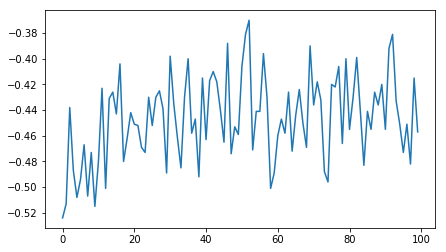

In [212]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_1000 = k_SARSA_Control(env, k=1000)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_1000.control(epsilon,num_episodes,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_1000_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### sarsa 1000 decay




  0%|          | 0/100 [00:00<?, ?it/s]


 93%|█████████▎| 93/100 [00:00<00:00, 926.85it/s]


100%|██████████| 100/100 [00:00<00:00, 889.86it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 64%|██████▍   | 64/100 [00:00<00:00, 637.60it/s]


100%|██████████| 100/100 [00:00<00:00, 618.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 666.49it/s]


100%|██████████| 100/100 [00:00<00:00, 643.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 63%|██████▎   | 63/100 [00:00<00:00, 624.12it/s]


100%|██████████| 100/100 [00:00<00:00, 610.11it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 839.01it/s]


100%|██████████| 100/100 [00:00<00:00, 777.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 916.78it/s]


100%|██████████| 100/100 [00:00<00:00, 863.74it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 869.77it/s]


100%|██████████| 100/

  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 785.18it/s]


100%|██████████| 100/100 [00:00<00:00, 681.68it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 664.54it/s]


100%|██████████| 100/100 [00:00<00:00, 641.72it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 68%|██████▊   | 68/100 [00:00<00:00, 669.00it/s]


100%|██████████| 100/100 [00:00<00:00, 667.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 55%|█████▌    | 55/100 [00:00<00:00, 546.02it/s]


100%|██████████| 100/100 [00:00<00:00, 636.77it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 899.54it/s]


100%|██████████| 100/100 [00:00<00:00, 876.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 905.52it/s]


100%|██████████| 100/100 [00:00<00:00, 824.10it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 62%|██████▏   | 62/100 [00:00<00:00, 614.70it/s]


100%|██████████| 100/100

  0%|          | 0/100 [00:00<?, ?it/s]


 55%|█████▌    | 55/100 [00:00<00:00, 549.44it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 508.34it/s]


100%|██████████| 100/100 [00:00<00:00, 470.68it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 61%|██████    | 61/100 [00:00<00:00, 608.03it/s]


100%|██████████| 100/100 [00:00<00:00, 681.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 875.88it/s]


100%|██████████| 100/100 [00:00<00:00, 823.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 783.47it/s]


100%|██████████| 100/100 [00:00<00:00, 783.91it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1012.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 876.77it/s]


100%|██████████| 100/100 [00:00<00:00, 796.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 68%|██████▊   | 68/100 [00:00<00:00, 668.95it/s]


100%|██████████| 100/10

100%|██████████| 100/100 [00:00<00:00, 518.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 73%|███████▎  | 73/100 [00:00<00:00, 722.93it/s]


100%|██████████| 100/100 [00:00<00:00, 699.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 47%|████▋     | 47/100 [00:00<00:00, 468.44it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 472.09it/s]


100%|██████████| 100/100 [00:00<00:00, 462.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 51%|█████     | 51/100 [00:00<00:00, 507.77it/s]


 90%|█████████ | 90/100 [00:00<00:00, 464.47it/s]


100%|██████████| 100/100 [00:00<00:00, 434.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 45%|████▌     | 45/100 [00:00<00:00, 445.24it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 434.22it/s]


100%|██████████| 100/100 [00:00<00:00, 423.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 61%|██████    | 61/100 [00:00<00:00, 602.86it/s]


100%|██████████| 100/100 [00:00<00:00, 625.37it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊ 

  0%|          | 0/100 [00:00<?, ?it/s]


 52%|█████▏    | 52/100 [00:00<00:00, 507.77it/s]


100%|██████████| 100/100 [00:00<00:00, 524.52it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 738.55it/s]


100%|██████████| 100/100 [00:00<00:00, 689.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 778.34it/s]


100%|██████████| 100/100 [00:00<00:00, 702.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 60%|██████    | 60/100 [00:00<00:00, 598.55it/s]


100%|██████████| 100/100 [00:00<00:00, 575.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 43%|████▎     | 43/100 [00:00<00:00, 425.38it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 446.96it/s]


100%|██████████| 100/100 [00:00<00:00, 427.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 32%|███▏      | 32/100 [00:00<00:00, 315.80it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 357.50it/s]


100%|██████████| 100/100 [00:00<00:00, 430.16it/s]


  0%|         

100%|██████████| 100/100 [00:00<00:00, 591.07it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 739.25it/s]


100%|██████████| 100/100 [00:00<00:00, 686.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 788.60it/s]


100%|██████████| 100/100 [00:00<00:00, 684.09it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 54%|█████▍    | 54/100 [00:00<00:00, 535.74it/s]


100%|██████████| 100/100 [00:00<00:00, 522.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 67%|██████▋   | 67/100 [00:00<00:00, 666.54it/s]


100%|██████████| 100/100 [00:00<00:00, 615.06it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 54%|█████▍    | 54/100 [00:00<00:00, 535.80it/s]


100%|██████████| 100/100 [00:00<00:00, 510.91it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 794.35it/s]


100%|██████████| 100/100 [00:00<00:00, 690.28it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100

100%|██████████| 100/100 [00:00<00:00, 1291.77it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1265.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1092.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 954.38it/s]


100%|██████████| 100/100 [00:00<00:00, 913.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 959.79it/s]


100%|██████████| 100/100 [00:00<00:00, 931.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 997.39it/s]





  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1032.25it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1199.69it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1164.10it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<

 78%|███████▊  | 78/100 [00:00<00:00, 774.72it/s]


100%|██████████| 100/100 [00:00<00:00, 684.78it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 75%|███████▌  | 75/100 [00:00<00:00, 743.32it/s]


100%|██████████| 100/100 [00:00<00:00, 718.92it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 769.12it/s]


100%|██████████| 100/100 [00:00<00:00, 690.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 70%|███████   | 70/100 [00:00<00:00, 690.32it/s]


100%|██████████| 100/100 [00:00<00:00, 629.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 62%|██████▏   | 62/100 [00:00<00:00, 615.88it/s]


100%|██████████| 100/100 [00:00<00:00, 590.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 733.58it/s]


100%|██████████| 100/100 [00:00<00:00, 732.58it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 83%|████████▎ | 83/100 [00:00<00:00, 828.00it/s]


100%|██████████| 100/100 [00:00<00:00, 826.97it/s]


  0%|        

  0%|          | 0/100 [00:00<?, ?it/s]


 69%|██████▉   | 69/100 [00:00<00:00, 688.49it/s]


100%|██████████| 100/100 [00:00<00:00, 596.40it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 909.97it/s]


100%|██████████| 100/100 [00:00<00:00, 837.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 61%|██████    | 61/100 [00:00<00:00, 606.15it/s]


100%|██████████| 100/100 [00:00<00:00, 518.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 95%|█████████▌| 95/100 [00:00<00:00, 948.85it/s]


100%|██████████| 100/100 [00:00<00:00, 851.43it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 84%|████████▍ | 84/100 [00:00<00:00, 829.24it/s]


100%|██████████| 100/100 [00:00<00:00, 718.20it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 66%|██████▌   | 66/100 [00:00<00:00, 656.85it/s]


100%|██████████| 100/100 [00:00<00:00, 592.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 97%|█████████▋| 97/100 [00:00<00:00, 957.47it/s]


100%|██████████| 100/100

  0%|          | 0/100 [00:00<?, ?it/s]


 70%|███████   | 70/100 [00:00<00:00, 699.87it/s]


100%|██████████| 100/100 [00:00<00:00, 750.13it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 935.63it/s]


100%|██████████| 100/100 [00:00<00:00, 874.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 990.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/100 [00:00<00:00, 932.81it/s]


100%|██████████| 100/100 [00:00<00:00, 872.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 79%|███████▉  | 79/100 [00:00<00:00, 784.18it/s]


100%|██████████| 100/100 [00:00<00:00, 685.15it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 58%|█████▊    | 58/100 [00:00<00:00, 574.92it/s]


100%|██████████| 100/100 [00:00<00:00, 580.95it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 55%|█████▌    | 55/100 [00:00<00:00, 540.42it/s]


100%|██████████| 100/100 [00:00<00:00, 527.30it/s]


  0%|          | 0/100 

 66%|██████▌   | 66/100 [00:00<00:00, 656.68it/s]


100%|██████████| 100/100 [00:00<00:00, 679.48it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1058.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 98%|█████████▊| 98/100 [00:00<00:00, 974.42it/s]


100%|██████████| 100/100 [00:00<00:00, 914.34it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 762.91it/s]


100%|██████████| 100/100 [00:00<00:00, 687.88it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 50%|█████     | 50/100 [00:00<00:00, 495.01it/s]


100%|██████████| 100/100 [00:00<00:00, 552.51it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 55%|█████▌    | 55/100 [00:00<00:00, 545.84it/s]


100%|██████████| 100/100 [00:00<00:00, 548.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 903.67it/s]


100%|██████████| 100/100 [00:00<00:00, 858.25it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 94%|█████████▍| 94/10

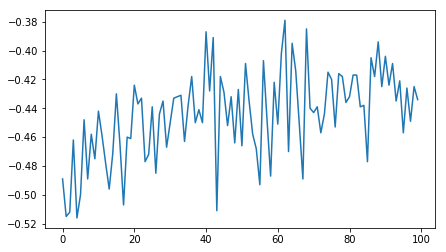

In [213]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    sarsa_decay_1000 = k_SARSA_Control(env, k=1000)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = sarsa_decay_1000.control(epsilon,num_episodes,decay_e=True,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
sarsa_decay_1000_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### Q learning




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1017.42it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1119.61it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1346.64it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1069.27it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1251.66it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 78%|███████▊  | 78/100 [00:00<00:00, 778.20it/s]


100%|██████████| 100/100 [00:00<00:00, 773.65it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 982.20it/s]


100%|██████████| 100/100 [00:00<00:00, 882.75it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 99%|█████████▉| 99/100 [00:00<00:00, 989.43it/s]


100%|██████████| 100/100 [00:00<00:00, 952.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 83%|████████▎ | 83/100 [00:00<00:

  0%|          | 0/100 [00:00<?, ?it/s]


 87%|████████▋ | 87/100 [00:00<00:00, 860.61it/s]


100%|██████████| 100/100 [00:00<00:00, 836.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1205.21it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1104.36it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1297.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1243.16it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 89%|████████▉ | 89/100 [00:00<00:00, 886.16it/s]


100%|██████████| 100/100 [00:00<00:00, 826.29it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 794.04it/s]


100%|██████████| 100/100 [00:00<00:00, 773.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 946.01it/s]


100%|██████████| 100/100 [00:00<00:00, 865.43it/s]


  0%|          | 0/100 [00:0

100%|██████████| 100/100 [00:00<00:00, 1219.35it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1168.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 77%|███████▋  | 77/100 [00:00<00:00, 769.42it/s]


100%|██████████| 100/100 [00:00<00:00, 743.52it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 898.19it/s]


100%|██████████| 100/100 [00:00<00:00, 852.41it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1097.80it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 74%|███████▍  | 74/100 [00:00<00:00, 735.81it/s]


100%|██████████| 100/100 [00:00<00:00, 715.16it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1024.23it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1191.81it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1182.47it/s]


  0%|          | 0/100 [0

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1052.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 85%|████████▌ | 85/100 [00:00<00:00, 847.36it/s]


100%|██████████| 100/100 [00:00<00:00, 798.12it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 70%|███████   | 70/100 [00:00<00:00, 696.23it/s]


100%|██████████| 100/100 [00:00<00:00, 678.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 80%|████████  | 80/100 [00:00<00:00, 786.99it/s]


100%|██████████| 100/100 [00:00<00:00, 739.64it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 75%|███████▌  | 75/100 [00:00<00:00, 748.83it/s]


100%|██████████| 100/100 [00:00<00:00, 722.64it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 994.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 98%|█████████▊| 98/100 [00:00<00:00, 977.83it/s]


100%|██████████| 100/100 [00:00<00:00, 907.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<

100%|██████████| 100/100 [00:00<00:00, 780.93it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 90%|█████████ | 90/100 [00:00<00:00, 892.45it/s]


100%|██████████| 100/100 [00:00<00:00, 867.33it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1025.16it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1078.85it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1221.72it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1031.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1230.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 76%|███████▌  | 76/100 [00:00<00:00, 758.46it/s]


100%|██████████| 100/100 [00:00<00:00, 691.22it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 91%|█████████ | 91/100 [00:00<00:00, 908.39it/s]


100%|██████████| 100/100 [00:00<00:00, 879.69it/s]


  0%|          | 0/100 [00

100%|██████████| 100/100 [00:00<00:00, 677.94it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 994.08it/s]





  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 945.23it/s]


100%|██████████| 100/100 [00:00<00:00, 915.24it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1297.96it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1089.29it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 95%|█████████▌| 95/100 [00:00<00:00, 939.00it/s]


100%|██████████| 100/100 [00:00<00:00, 908.87it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 88%|████████▊ | 88/100 [00:00<00:00, 879.07it/s]


100%|██████████| 100/100 [00:00<00:00, 839.19it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 66%|██████▌   | 66/100 [00:00<00:00, 656.86it/s]


100%|██████████| 100/100 [00:00<00:00, 651.63it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 52%|█████▏    | 52/100 [00

  0%|          | 0/100 [00:00<?, ?it/s]


 96%|█████████▌| 96/100 [00:00<00:00, 951.24it/s]


100%|██████████| 100/100 [00:00<00:00, 903.73it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1065.37it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1148.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1086.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1127.82it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 83%|████████▎ | 83/100 [00:00<00:00, 825.12it/s]


100%|██████████| 100/100 [00:00<00:00, 802.70it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 83%|████████▎ | 83/100 [00:00<00:00, 824.15it/s]


100%|██████████| 100/100 [00:00<00:00, 704.84it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1054.54it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1193.53it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1210.39it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1438.59it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1140.67it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1279.84it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1326.03it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1574.85it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1473.17it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1420.86it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1453.80it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 897.55it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 95%|█████████▌| 95/100 [00:00<00:00, 929.29it/s]


100%|██████████| 100/100 [00:00<00:00, 881.73it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


 92%|█████████▏| 92/100 [00:00<00:00, 919.59it/s]


100%|██████████| 100/100 [00:00<00:00, 889.66it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1159.79it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1178.00it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1144.50it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1179.01it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1341.61it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1359.64it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:

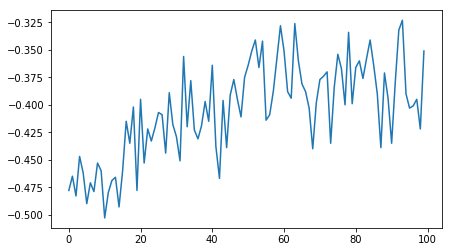

In [214]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    q_learner = Q_Learner(env)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = q_learner.control(epsilon,num_episodes,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
q_learner_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

#### TD Lambda

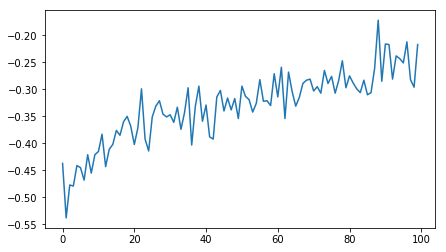

In [215]:
total_rewards = np.zeros(num_episodes)
for n in range(num_runs):
    env = Environment()
    td_lambda = TDLambda(env)
    rewards = []
    for n in range(1,num_episodes+1):
        _, avg_reward = td_lambda.control(epsilon,num_episodes,get_rewards=True)
        rewards.append(avg_reward)
#     rewards = [(1.0*sum(rewards[:i]))/i for i in range(1,len(rewards)+1)]
#     print(len(rewards))
    total_rewards+=rewards
total_rewards/=num_runs
td_lambda_rewards = total_rewards
plt.figure(figsize=(7,4))
plt.plot(np.arange(100), total_rewards)
plt.show()

In [275]:
rewards = [sarsa_1_rewards, sarsa_decay_1_rewards, sarsa_10_rewards, sarsa_decay_10_rewards, sarsa_100_rewards, sarsa_decay_100_rewards,\
         sarsa_1000_rewards, sarsa_decay_1000_rewards, q_learner_rewards, td_lambda_rewards]
names = ['1-sarsa', '1-sarsa-decay', '10-sarsa', '10-sarsa-decay', '100-sarsa', '100-sarsa-decay',\
         '1000-sarsa', '1000-sarsa-decay', 'q-learning', 'td-lambda']

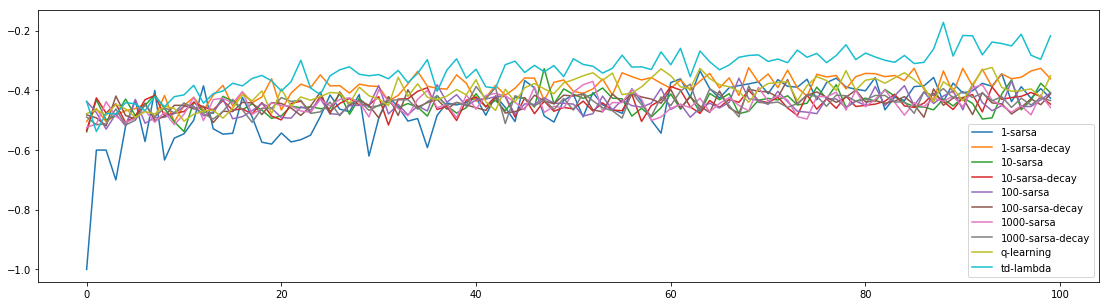

In [250]:
plt.figure(figsize=(19,5))
for i in range(len(rewards)):
    plt.plot(np.arange(num_episodes),rewards[i], label=names[i])
plt.legend()
plt.show()

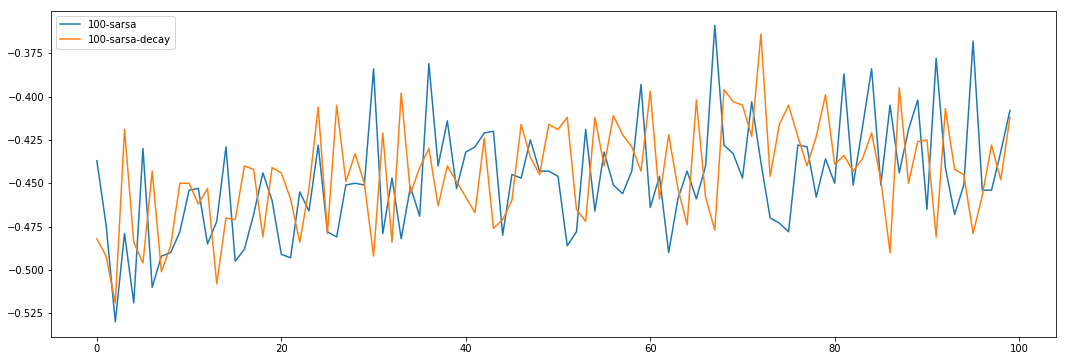

In [276]:
plt.figure(figsize=(18,6))
names = [names[4],names[5]]#, names[4],names[6]]
rewards = [rewards[4],rewards[5]]#, rewards[4],rewards[6]]
for i in range(len(rewards)):
    plt.plot(np.arange(num_episodes),rewards[i], label=names[i])
plt.legend()
plt.show()

## Change in performance with increasing learning rate

#### Sarsa 1

100%|██████████| 100000/100000 [01:55<00:00, 863.87it/s]


100%|██████████| 100000/100000 [01:54<00:00, 871.69it/s]


100%|██████████| 100000/100000 [01:57<00:00, 851.16it/s]


100%|██████████| 100000/100000 [02:05<00:00, 794.51it/s]


100%|██████████| 100000/100000 [32:28<00:00, 51.32it/s]  


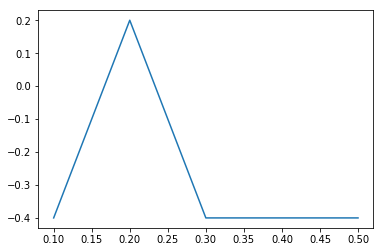

In [94]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_1 = k_SARSA_Control(env, k=1, alpha=alpha)
    q = sarsa_1.control(epsilon,num_episodes)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_1_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### sarsa 1 decay

In [92]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_1_decay = k_SARSA_Control(env, k=1, alpha=alpha)
    q = sarsa_1_decay.control(epsilon,num_episodes,decay_e=True)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_1_decay_rewards = rewards

100%|██████████| 100000/100000 [01:37<00:00, 1021.50it/s]


100%|██████████| 100000/100000 [01:30<00:00, 1099.16it/s]


100%|██████████| 100000/100000 [01:29<00:00, 1117.98it/s]


100%|██████████| 100000/100000 [02:15<00:00, 740.35it/s]


100%|██████████| 100000/100000 [02:01<00:00, 822.90it/s]


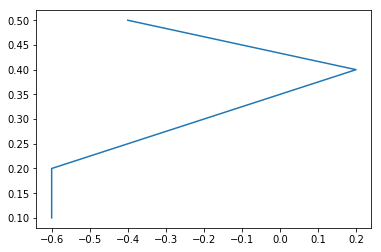

In [93]:
plt.plot(rewards,alphas)

#### Sarsa 10

100%|██████████| 100000/100000 [11:38<00:00, 143.23it/s] 


100%|██████████| 100000/100000 [01:55<00:00, 864.82it/s]


100%|██████████| 100000/100000 [02:37<00:00, 635.41it/s]


100%|██████████| 100000/100000 [02:37<00:00, 633.97it/s]


100%|██████████| 100000/100000 [02:10<00:00, 763.48it/s]


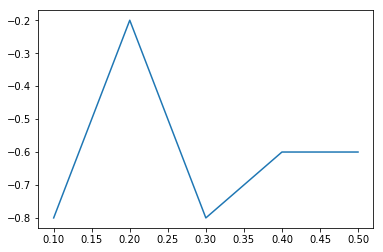

In [95]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_10 = k_SARSA_Control(env, k=10, alpha=alpha)
    q = sarsa_10.control(epsilon,num_episodes)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_10_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### Sarsa 10 decay 

100%|██████████| 100000/100000 [02:05<00:00, 799.40it/s]


100%|██████████| 100000/100000 [02:05<00:00, 798.23it/s]


100%|██████████| 100000/100000 [02:03<00:00, 811.33it/s]


100%|██████████| 100000/100000 [01:52<00:00, 888.93it/s]


100%|██████████| 100000/100000 [01:56<00:00, 856.36it/s]


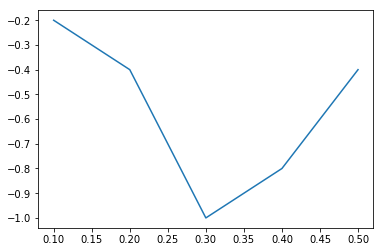

In [96]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_10_decay = k_SARSA_Control(env, k=10, alpha=alpha)
    q = sarsa_10_decay.control(epsilon,num_episodes,decay_e=True)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_10_decay_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### Sarsa 100 

100%|██████████| 100000/100000 [02:00<00:00, 826.72it/s]


100%|██████████| 100000/100000 [02:08<00:00, 780.36it/s]


100%|██████████| 100000/100000 [01:57<00:00, 847.56it/s]


100%|██████████| 100000/100000 [01:58<00:00, 846.59it/s]


100%|██████████| 100000/100000 [02:08<00:00, 780.08it/s]


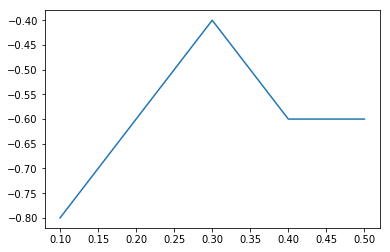

In [97]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_100 = k_SARSA_Control(env, k=100, alpha=alpha)
    q = sarsa_100.control(epsilon,num_episodes)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_100_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### Sarsa 100 decay 

100%|██████████| 100000/100000 [02:07<00:00, 785.19it/s]


100%|██████████| 100000/100000 [02:10<00:00, 765.06it/s]


100%|██████████| 100000/100000 [02:05<00:00, 794.00it/s]


100%|██████████| 100000/100000 [01:49<00:00, 914.85it/s]


100%|██████████| 100000/100000 [02:00<00:00, 827.65it/s]


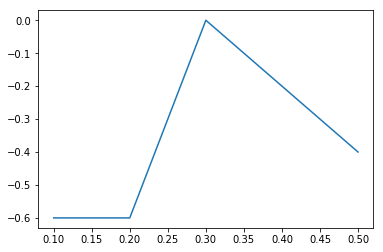

In [98]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_100_decay = k_SARSA_Control(env, k=100, alpha=alpha)
    q = sarsa_100_decay.control(epsilon,num_episodes,decay_e=True)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_100_decay_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### Sarsa 1000

100%|██████████| 100000/100000 [02:53<00:00, 578.01it/s]


100%|██████████| 100000/100000 [02:51<00:00, 584.15it/s]


100%|██████████| 100000/100000 [02:45<00:00, 604.42it/s]


100%|██████████| 100000/100000 [02:46<00:00, 600.95it/s]


100%|██████████| 100000/100000 [02:43<00:00, 611.60it/s]


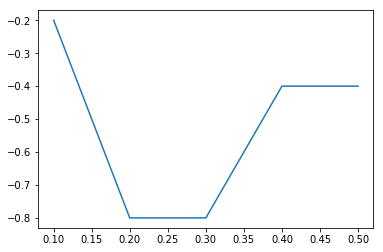

In [99]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_1000 = k_SARSA_Control(env, k=1000, alpha=alpha)
    q = sarsa_1000.control(epsilon,num_episodes)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_1000_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### Sarsa 1000 decay 

100%|██████████| 100000/100000 [02:53<00:00, 575.57it/s]


100%|██████████| 100000/100000 [02:56<00:00, 566.96it/s]


100%|██████████| 100000/100000 [02:55<00:00, 568.89it/s]


100%|██████████| 100000/100000 [02:47<00:00, 595.85it/s]


100%|██████████| 100000/100000 [02:38<00:00, 631.59it/s]


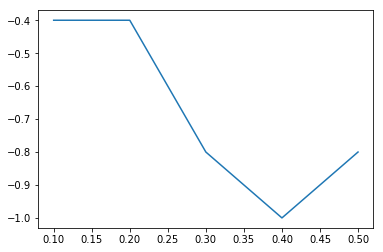

In [100]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    sarsa_1000_decay = k_SARSA_Control(env, k=1000, alpha=alpha)
    q = sarsa_1000_decay.control(epsilon,num_episodes,decay_e=True)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
sarsa_1000_decay_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### Q learning

100%|██████████| 100000/100000 [02:10<00:00, 765.00it/s]


100%|██████████| 100000/100000 [02:17<00:00, 725.53it/s]


100%|██████████| 100000/100000 [02:15<00:00, 735.79it/s]


100%|██████████| 100000/100000 [02:01<00:00, 823.05it/s]


100%|██████████| 100000/100000 [02:09<00:00, 774.38it/s]


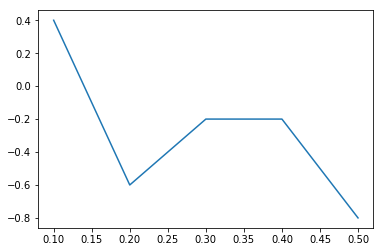

In [101]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    q_learner = Q_Learner(env,alpha=alpha)
    q = q_learner.control(epsilon,num_episodes)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
q_learner_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

#### TD Lambda

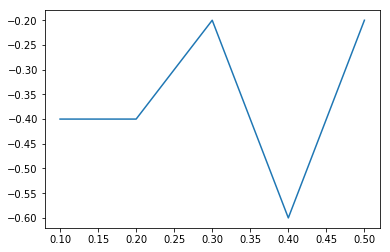

In [102]:
num_episodes = 100000
test_episodes = 10
epsilon = 0.1
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
rewards = []
for alpha in alphas:
    env = Environment()
    td_lambda = TDLambda(env,alpha=alpha)
    q = td_lambda.control(epsilon,num_episodes)
    avg_reward = agent.gen_test_episodes(test_episodes)
    rewards.append(avg_reward)
td_lambda_rewards = rewards
plt.plot(alphas,rewards)
plt.show()

In [201]:
r = [sarsa_1_rewards, sarsa_1_decay_rewards, sarsa_10_rewards, sarsa_10_decay_rewards, sarsa_100_rewards, sarsa_100_decay_rewards,\
         sarsa_1000_rewards, sarsa_1000_decay_rewards, q_learner_rewards, td_lambda_rewards]
names = ['1-sarsa', '1-sarsa-decay', '10-sarsa', '10-sarsa-decay', '100-sarsa', '100-sarsa-decay',\
         '1000-sarsa', '1000-sarsa-decay', 'q-learning', 'td-lambda']

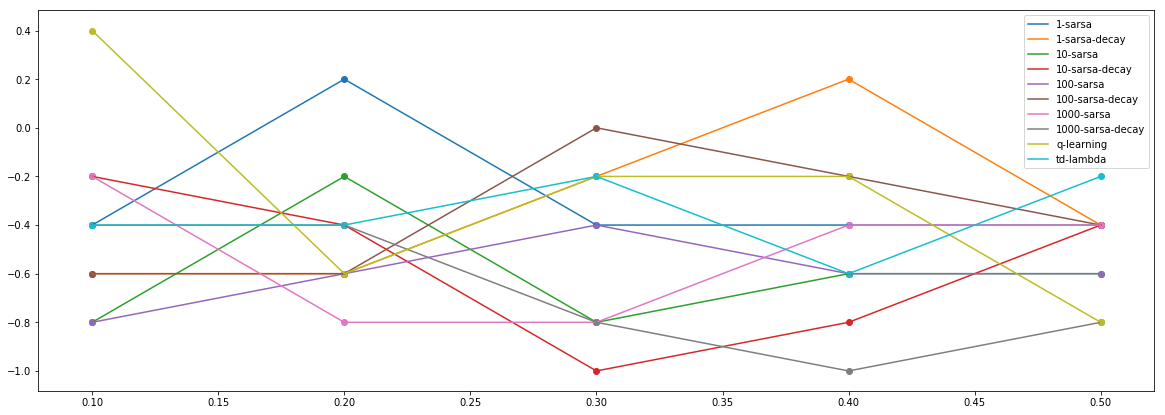

In [174]:
# from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize=(20,7))
for i in range(len(r)):
#     xnew = np.linspace(min(r),max(r),300)
#     spl = make_interp_spline(r, power, k=3)
#     power_smooth = spl(xnew)
#     plt.plot(xnew,power_smooth)
    plt.plot(alphas,r[i], label=names[i])
    plt.scatter(alphas,r[i])
plt.legend(loc="upper right")
plt.show()

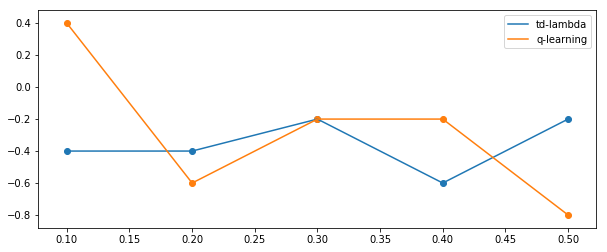

In [203]:
r = [r[-1],r[-2]]
names = [names[-1],names[-2]]
plt.figure(figsize=(10,4))
for i in range(len(r)):
    plt.plot(alphas,r[i],label=names[i])
    plt.scatter(alphas,r[i])
plt.legend(loc="upper right")
plt.show()